In [1]:
### Library functions
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
import random 
from matplotlib import animation
import networkx.algorithms.centrality as nx_centrality
from collections import deque
from matplotlib import animation
import math

# Dataset
## Training dataset
The global parameters of the generate_random_graph function:
1. FAKE_DIFF_ITER: the fake nodes diffusion iteration
2. FAKE_SEED_NUM: the initial fake seed set number
3. NODE_NUM: the graph nodes number
4. EDGE_NUM: the graph edges number 
5. M_INDEX: the generate graph method index

In [2]:
def generate_random_graph(difusion_iteration, method_index, fake_seed_num, num_nodes, num_edges, probability = 0.5,m = 2, radius = None, k_nearest_neighbor = None, degree = None, seed = None):
    random_graph = nx.Graph()
    if method_index == 0:
        random_graph = nx.gnm_random_graph(num_nodes, num_edges)

    elif method_index == 1:
        random_graph = nx.erdos_renyi_graph(num_nodes, probability)

    elif method_index == 2:
         # m means the edges number from the create point to existing point
        random_graph = nx.barabasi_albert_graph(num_nodes, m)

    elif method_index == 3:
        random_graph = nx.watts_strogatz_graph(num_nodes, k_nearest_neighbor, probability)
    for (u,v) in random_graph.edges:
        if FIXED == True:
            random_graph.edges[u, v]["weight"] = PROBABILITY
        else:
            random_graph.edges[u, v]["weight"] =  random.uniform(0,1)
    for node in random_graph.nodes():
        random_graph.nodes[node]['state'] = 0 # 0初始状态；1:true；2:fake
    node_number = random_graph.number_of_nodes()
    start_node_index = [0] *fake_seed_num
    index_range = range(0,  node_number)
    fake_seed_set = random.sample(index_range, fake_seed_num)
    fake_active_nodes = fake_seed_set.copy()
    fake_nodes_set = fake_seed_set.copy()
    for _ in range(difusion_iteration):
        temp_fake = []
        for v in fake_active_nodes:
            for nbr in random_graph.neighbors(v): 
                if random_graph.nodes[nbr]['state'] == 0 : 
                    edge_data = random_graph.get_edge_data(v, nbr)
                    if random.uniform(0, 1) < edge_data['weight']:
                        fake_nodes_set.append(nbr)
                        temp_fake.append(nbr)
                        random_graph.nodes[nbr]['state'] = 2
        fake_active_nodes = temp_fake.copy()
        temp_fake.clear()    
    for node in fake_nodes_set:
        random_graph.nodes[node]['state'] = 2
        
    return random_graph,fake_active_nodes,fake_seed_set,fake_nodes_set


## Create and normalize test data

In [3]:
import scanpy as sc 
import scipy as sp
import scipy.sparse  # call as sp.sparse
import scipy.io as sio

# filename_ca_HepTh = r"D:\course (Kou Hari)\2023 semaster 1\COMP5703 Capstone\data\ca-HepTh.mtx"
# filename_ca_GrQc = r"D:\course (Kou Hari)\2023 semaster 1\COMP5703 Capstone\data\ca-GrQc.mtx"
# filename_tech_p2p_gnutella = r"D:\course (Kou Hari)\2023 semaster 1\COMP5703 Capstone\data\tech-p2p-gnutella.mtx"
filename_ca_HepTh = 'ca-HepTh.mtx'
filename_ca_GrQc = 'ca-GrQc.mtx'
filename_tech_p2p_gnutella = 'tech-p2p-gnutella.mtx'
filename_fb = 'fb-pages-food.mtx'

In [4]:
def read_graph(filename):
    
#     adata = sc.read(filename)
#     sparse_matrix = sp.load_npz(filename)
    data = sio.mmread(filename)
    G = nx.from_scipy_sparse_array(data)
#     G = nx.from_scipy_sparse_array(adata.X, create_using=nx.MultiGraph)
    print("node number:",G.number_of_nodes())
    print("edge number:",G.number_of_edges())
    return G, G.number_of_nodes(), G.number_of_edges()

In [5]:
# G_ca_HepTh,N_ca_HepTh,E_ca_HepTh= read_graph(filename_ca_HepTh)

In [6]:
G_ca_GrQc,N_ca_GrQc,E_ca_GrQc = read_graph(filename_ca_GrQc)

node number: 5242
edge number: 14496


In [7]:
# G_tech_p2p_gnutella,N_tech_p2p_gnutella,E_tech_p2p_gnutella = read_graph(filename_tech_p2p_gnutella)

In [8]:
G_fb, N_fb, E_fb = read_graph(filename_fb)

node number: 620
edge number: 2102


In [9]:
def normalization_graph(graph):
    graph_node_number = graph.number_of_nodes()
    graph_edge_number = graph.number_of_edges()
    for node in graph.nodes():
        graph.nodes[node]['state'] = 0
    for (u,v) in graph.edges():
        graph.edges[u,v]['weight'] = random.uniform(0,1)
    return graph,graph_node_number,graph_edge_number

In [10]:
def fake_nodes_diffusion(graph,fake_seed_num,iteration):
    node_number = graph.number_of_nodes()
    start_node_index = [0] *fake_seed_num
    index_range = range(0,  node_number)
    fake_seed_set = random.sample(index_range, fake_seed_num)
    fake_active_nodes = fake_seed_set.copy()
    fake_nodes_set = fake_seed_set.copy()
    for node in fake_seed_set:
        graph.nodes[node]['state'] = 2
    #fake news diffusion
    for _ in range(iteration):
        temp_fake = []
        for v in fake_active_nodes:
            for nbr in graph.neighbors(v): 
                if graph.nodes[nbr]['state'] == 0 : 
                    edge_data = graph.get_edge_data(v, nbr)
                    if random.uniform(0, 1) < edge_data['weight']:
                        fake_nodes_set.append(nbr)
                        temp_fake.append(nbr)
                        graph.nodes[nbr]['state'] = 2
        fake_active_nodes = temp_fake.copy()  
    for node in fake_nodes_set:
        random_graph.nodes[node]['state'] = 2
    return graph,fake_active_nodes

In [11]:
def statistic_draw_graph(Graph,draw = False):
    color_list = []
    fake = 0
    true = 0
    normal = 0
    for node in Graph.nodes():
        if Graph.nodes[node]['state'] == 0:
            normal += 1
            color_list.append('blue')
        elif Graph.nodes[node]['state'] == 1:
            true += 1
            color_list.append('green')
        elif Graph.nodes[node]['state'] == 2:
            fake += 1
            color_list.append('red')
    print("normal nodes number:",normal)
    print("true nodes number:",true)
    print("fake nodes number:",fake)
    print("the edge of graph:",Graph.number_of_edges())
    #nx.draw(Graph, node_color= color_list) 
    if draw:
        nx.draw_circular(Graph, node_color= color_list)
        plt.show()

# Environment Class
The global parameters in the Environment Class:
1. ITERATION: control the diffusion times during the true and fake nodes antagonistic process
2. MAX_STEP: control the max step of this epoch
3. SEED_SIZE: the initial size of the seed set, the initial parameters of Env class.

The input variable of the Env() class:
1. graph: the training graph or testing graph
2. seed_size: SEED_SIZE;the initial size of the seed set
3. fake_set: the initial fake

The functions in the Env class:
1. reset: reset the parameters
2. step: the experiment excuation progress
3. select_initial_seeds: select the initial seed randomly
4. select_initial_seeds_rules: select the intial seed set according to different criterion
5. add_seed: add the seed nodes according to the action number from the agent
6. get_state: get the current state of the graph
7. diffusion_process: the procees of the true and fake nodes antagonistic
8. get_image: draw the image of the graph

In [12]:
class Env():
    def __init__(self, graph,seed_size,fake_set):
        self.graph_initial = graph
        self.seed_size = seed_size
        self.seed_set = []
        self.fake_set = fake_set
        self.state = None
        self.reset()

    def reset(self):
        #select the seed set:
        self.graph = self.graph_initial.copy()
        self.step_count = 0
        self.add_number = 0
        self.seed_set, action = self.select_initial_seeds_rules(self.graph,self.seed_size)
        self.true_active_nodes = self.seed_set.copy()
        self.fake_active_nodes = self.fake_set.copy()
        self.state = self.get_state()
        return self.state, action
    
    def step(self,action):
        count_state0 = 0
        for node in self.graph.nodes():
            if self.graph.nodes[node]['state'] == 0:
                count_state0 += 1
        if action > 0 and (len(self.seed_set) + ADD_SEED_NUMBER <= self.graph.number_of_nodes()) and count_state0 >= ADD_SEED_NUMBER:
            self.add_number += 1
            centrality_methods = ["None", "random", "degree", "closeness", "betweenness", "eigenvector"]
            centrality_method = centrality_methods[action]
            self.seed_set = self.add_seed(self.graph,self.seed_set,action,ADD_SEED_NUMBER)
            if(self.true_active_nodes[-ADD_SEED_NUMBER:]!= self.seed_set[-ADD_SEED_NUMBER:]):
                self.true_active_nodes.extend(self.seed_set[-ADD_SEED_NUMBER:])
        self.graph,self.true_active_nodes,self.fake_active_nodes = self.diffusion_process(self.graph,
                                                                                     self.true_active_nodes,
                                                                               self.fake_active_nodes,ITERATION)
        #print("current image:")
        #self.get_image(self.graph)
        
        # terminal condition                                                                    
        all_true_nodes = []
        all_fake_nodes = []
        normal_nodes= []                                                                             
        for node in self.graph.nodes():
            if self.graph.nodes[node]['state'] == 1:
                all_true_nodes.append(node)
            elif self.graph.nodes[node]['state'] == 2:
                all_fake_nodes.append(node)
            elif self.graph.nodes[node]['state'] == 0:
                normal_nodes.append(node)
        number_nodes = len(self.graph.nodes())
        number_true_nodes = len(all_true_nodes) 
        number_fake_nodes = len(all_fake_nodes)
        # terminal condition: over the MAX_STEP / less 1% nodes are normal nodes
        terminated = bool(self.step_count >= MAX_STEP 
                        or len(normal_nodes)<=0.1 * number_nodes) 
        penatly = math.pow(1.05,self.add_number)
        if not terminated:
            if len(all_true_nodes)>len(all_fake_nodes):
                reward = (len(all_true_nodes)  - len(all_fake_nodes) - penatly + 5)/(len(all_true_nodes) + len(all_fake_nodes))
            else:
                reward = (len(all_true_nodes)  - len(all_fake_nodes) - penatly)/(len(all_true_nodes) + len(all_fake_nodes))
            done = False
            self.step_count +=1
        else: 
            # when this iteration is end, give a little big reward.
            reward = 30
            done = True
            
#             self.step_count >= MAX_STEP: 
#             # when this iteration is end, give a little big reward.
#             reward = 20
#             done = True
#         elif len(normal_nodes)<=0.01 * number_nodes:
#             reward = 30
#             done = True
            
#         print(reward)
        self.state = self.get_state()
        return self.state, reward ,done 
    # select the initial seed set randomly
    def select_initial_seeds(self, graph, seed_number):
        node_number = graph.number_of_nodes()
        start_node_index = [0] *seed_number
        index_range = range(0,  node_number)
        start_node_index = random.sample(index_range, seed_number)
        for node in graph.nodes():
            if node in start_node_index:
                graph.nodes[node]['state'] = 1
        return start_node_index
    # select the initial seed set according to different rules
    def select_initial_seeds_rules(self,graph,seed_number):
        # 1 random 2 "degree",3 "closeness", 4"betweenness", 5"eigenvector"
        action = random.randint(0,5)
        start_node_index = []
        centrality_scores = []
        if action == 0:   
            node_number = graph.number_of_nodes()
            start_node_index = [0] *seed_number
            index_range = range(0,  node_number)
            start_node_index = random.sample(index_range, seed_number)
        else:
            if action == 1:
                centrality_scores  = list(nx_centrality.degree_centrality(self.graph).values())
            elif action == 2:
                centrality_scores  = list(nx_centrality.degree_centrality(self.graph).values())
            elif action == 3:
                centrality_scores = list(nx_centrality.closeness_centrality(self.graph).values())
            elif action == 4:
                centrality_scores = list(nx_centrality.betweenness_centrality(self.graph).values())
            elif action == 5:
                centrality_scores = list(nx_centrality.eigenvector_centrality(self.graph).values())
            for _ in range(seed_number):
                max_number = max(centrality_scores)
                index = centrality_scores.index(max_number)
                while(graph.nodes[index]['state'] != 0):
                    centrality_scores[index] = -1
                    max_number = max(centrality_scores)
                    index = centrality_scores.index(max_number)  
                start_node_index.append(index)
                centrality_scores[index] = -1
        for node in graph.nodes():
            if node in start_node_index:
                graph.nodes[node]['state'] = 1
        return start_node_index,action
        
    def add_seed(self,graph,seed_set,action,add_number):
        # 1 random 2 "degree",3 "closeness", 4"betweenness", 5"eigenvector"
        new_seed_set = []
        new_seed_set = seed_set.copy()
        centrality_scores = []
        state0 = 0
        for node in graph.nodes():
            if graph.nodes[node]['state'] == 0:
                state0 += 1
        if state0 >= ADD_SEED_NUMBER:
            if action == 1:
                node_number = graph.number_of_nodes()
                for _ in range(ADD_SEED_NUMBER):
                    index = random.randint(0,node_number-1)
                    while (index in seed_set) or (graph.nodes[index]['state'] in [1,2])  :
                        index = random.randint(0,node_number-1)
                    new_seed_set.append(index)
                    graph.nodes[index]['state']  = 1

            else: 
                if action == 2:
                    centrality_scores  = list(nx_centrality.degree_centrality(self.graph).values())
                elif action == 3:
                    centrality_scores = list(nx_centrality.closeness_centrality(self.graph).values())
                elif action == 4:
                    centrality_scores = list(nx_centrality.betweenness_centrality(self.graph).values())
                elif action == 5:
                    centrality_scores = list(nx_centrality.eigenvector_centrality(self.graph).values())
                for node in seed_set:
                    centrality_scores[node] = -1
                for _ in range(ADD_SEED_NUMBER):
                    index = centrality_scores.index(max(centrality_scores))
                    while(graph.nodes[index]['state'] != 0):
                        index = centrality_scores.index(max(centrality_scores))
                        # print(index)
                        centrality_scores[index] = -1
                    # print("add_seed, index:",index)
                    new_seed_set.append(index)
                    graph.nodes[index]['state'] = 1
                    centrality_scores[index] = -1
        return new_seed_set
    def get_state(self):
        node_state = []
        for node in self.graph.nodes():
            node_state.append(self.graph.nodes[node]['state'])
        return nx.to_numpy_array(self.graph), len(self.seed_set), node_state
    
    def diffusion_process(self, G ,true_active_set,fake_active_set,itertaion):
        G = self.graph.copy()
        true_active_nodes = true_active_set.copy()
        fake_active_nodes = fake_active_set.copy()
        # print("true_active_nodes begin:",true_active_nodes)
        # print("fake_active_nodes begin:",fake_active_nodes)
        for _ in range(itertaion):
            tmp_true_nodes ={}
            for v in true_active_nodes: 
                for nbr in G.neighbors(v):
                    if G.nodes[nbr]['state'] in [0]:
                        edge_data = G.get_edge_data(v, nbr)
                        random_possibility = random.uniform(0, 1)
                        if random_possibility < edge_data['weight']:
                            G.nodes[nbr]['state'] == 3
                            tmp_true_nodes.update({nbr:random_possibility})
                            true_active_set.append(nbr)
                    else:
                        continue
            tmp_fake_nodes ={}
            for v in fake_active_nodes:
                for nbr in G.neighbors(v):
                    if G.nodes[nbr]['state'] in [0,3]:
                        edge_data = G.get_edge_data(v, nbr)
                        random_possibility = random.uniform(0, 1)
                        if random_possibility < edge_data['weight']:
                            tmp_fake_nodes.update({nbr:random_possibility})
                            fake_active_set.append(nbr)
                            G.nodes[nbr]['state'] == 4
            true_active_nodes = list(tmp_true_nodes.keys())
            fake_active_nodes = list(tmp_fake_nodes.keys())
            for node in tmp_true_nodes.keys():
                if node in tmp_fake_nodes.keys() :
                    if tmp_true_nodes.get(node) >= tmp_fake_nodes.get(node):
                        fake_active_set.remove(node)
                        fake_active_nodes.remove(node)
                    elif tmp_true_nodes.get(node) < tmp_fake_nodes.get(node):
                        true_active_set.remove(node)
                        true_active_nodes.remove(node)
                else:
                    continue
            for node in true_active_set:
                G.nodes[node]['state'] = 1
            for node in fake_active_set:
                G.nodes[node]['state'] = 2
            # print("true_active_nodes",true_active_set)
            # print("fake_active_nodes",fake_active_set)
        return G,true_active_nodes,fake_active_nodes

        
    def get_image(self,Graph):
        color_list = []
        for node in Graph.nodes():
            if Graph.nodes[node]['state'] == 0:
                color_list.append('blue')
            elif Graph.nodes[node]['state'] == 1:
                color_list.append('green')
            elif Graph.nodes[node]['state'] == 2:
                color_list.append('red')
        #nx.draw(Graph, node_color= color_list) 
        nx.draw_circular(Graph, node_color= color_list)
        plt.show()

# Agent

##  Device: GPU/CPU
Note:

if you use Macbook with Apple M1/M2 core, please run the code in the Mac Device;

if you use Windows with CUDA core, please run the code in the Windows Device;

### Mac Device

In [13]:
# # # if use MAC(Apple M1/M2) please run the follow codes
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# print(device)

### Windows Device

In [14]:
import torch
print("CUDA Available:", torch.cuda.is_available())

CUDA Available: True


In [15]:
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name()
    print("GPU Device Name:", device_name)

GPU Device Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [16]:
if torch.backends.cudnn.is_available():
    print("cuDNN Available")

cuDNN Available


In [17]:
# if use CUDA please run the follow codes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## DQN Agent

In [18]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate, gamma, epsilon, epsilon_decay):
        self.q_network = QNetwork(state_dim, action_dim).to(device)
        self.target_network = QNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=10000)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, action_dim)
        else:
            state = torch.tensor(state, dtype=torch.float32).to(device)
            q_values = self.q_network(state)
#           q_values = self.q_network(torch.tensor(state, dtype=torch.float32))
            return torch.argmax(q_values.cpu()).item()

    def remember(self, state, action, reward, next_state, done):
        #state = torch.tensor(state).float().unsqueeze(0)  # ensure state is a tensor
        self.memory.append((state, action, reward, next_state, done))

    def train(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state, done in minibatch:
            #print("next_state:", next_state)
            #state = torch.tensor(state, dtype=torch.float32).to(device)
            state_tensor = state_to_tensor(state).to(device)
            #print(state_tensor.shape)
            #print(self.q_network(state_tensor).shape)
            action_index = torch.tensor(action, dtype=torch.long)
            target = self.q_network(state_tensor)[0, action_index]
            #target = self.q_network(state_tensor)[action]
            if done:
                target_value = reward
            else:
                next_state_tensor = state_to_tensor(next_state).to(device)
                #next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
                next_q_values = self.target_network(next_state_tensor).detach()
                target_value = reward + self.gamma * torch.max(next_q_values).item()

            #loss = self.loss_fn(target, torch.tensor(float(target_value)))
            loss = self.loss_fn(target, torch.tensor(float(target_value)).to(device))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def save(self, path):
        torch.save(self.q_network.state_dict(), path)

    def load(self, path):
        self.q_network.load_state_dict(torch.load(path))
        self.target_network.load_state_dict(self.q_network.state_dict())

In [19]:
def state_to_tensor(state):
    graph, num_seed_nodes, node_state = state
    
    graph_tensor = torch.tensor(graph, dtype=torch.float32).view(-1).unsqueeze(0)
    num_seed_nodes_tensor = torch.tensor([num_seed_nodes], dtype=torch.float32).unsqueeze(0)
    node_state_tensor = torch.tensor(node_state, dtype=torch.float32).unsqueeze(0)
    
#     state_tensor = torch.cat((graph_tensor, num_seed_nodes_tensor, node_state_tensor), dim=1)
    state_tensor = torch.cat((num_seed_nodes_tensor, node_state_tensor), dim=1)
    
    return state_tensor

In [20]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)# (2500 + 50 + 2) (10000 + 100 + 2)
        
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training Function
The input valiable of train_dqn function:

1. agent: the initialized Agent class
2. env: the initialized Env class
3. batch_size: BATCH_SIZE
4. update_target_every: UPDATE;How many iterations to update the network
5. dqn_agent_name: the name of DQN agent, the file extension is '.pth'
6. brenchmark_action: Start benchmark comparison and specifying an action(1-5)
7. Demo: Whether state should be displayed or saved each time

In [21]:
def train_dqn(agent, env, episodes, batch_size, update_target_every,dqn_agent_name  = None,brenchmark_action = None,Demo = False):
    state_history= []
    rewards_list = []
    for episode in range(episodes):
        state,init_action = env.reset()
        if brenchmark_action is not None:
            init_action = brenchmark_action
        #print(state)
#         state = torch.tensor(state).float().unsqueeze(0)  # ensure state is a tensor
        total_reward = 0
        done = False

        while not done:
            state_tensor = state_to_tensor(state)
            #print(state_tensor)
            if brenchmark_action is not None:
                action = brenchmark_action
            else:
                action = agent.get_action(state_tensor)
            next_state, reward, done = env.step(action)
            #print(next_state)
            agent.remember(state, action, reward, next_state, done)
            agent.train(batch_size)
            total_reward += reward
            state = next_state
            if Demo:
                state_history.append(state)  # Add current state to state_history
        if not Demo:
            state_history.append(state)
        rewards_list.append(total_reward)
        if episode % update_target_every == 0:
            agent.update_target_network()

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
        agent.save(dqn_agent_name)
#     if dqn_agent_name is not None:
#         torch.save(agent,dqn_agent_name)
    return state_history, rewards_list

## Test Function

In [22]:
def test_dqn_model(model, env, episodes):
    rewards_list = []
    for episode in range(episodes):
        state,init_action = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_tensor = state_to_tensor(state)
            action = model.get_action(state_tensor)
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state
            
        rewards_list.append(total_reward)

        print(f"Test Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
        
    return rewards_list

In [23]:
def test_dqn(agent, env, episodes):
    rewards_list = []

    for episode in range(episodes):
        state,init_action = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_tensor = state_to_tensor(state)
            action = agent.get_action(state_tensor)
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state
            
        rewards_list.append(total_reward)

        print(f"Test Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
        
    return rewards_list

## Experiment

In [24]:
# the Global parameter of generate_random_graph
FAKE_DIFF_ITER = 1# the fake nodes diffusion iteration
FAKE_SEED_NUM = 5 # the initial fake seed set number
NODE_NUM = N_fb # the intial graph nodes number
EDGE_NUM = E_fb # the intial graph edges number
M_INDEX = 0 # the generate graph method index

# the Global parameter of Env class
ITERATION = 1 #control the diffusion times during the true and fake nodes antagonistic process
MAX_STEP = 40 # control the max step of this epoch
SEED_SIZE = 10 # the initial size of the seed set, the initial parameters of Env class.
ADD_SEED_NUMBER = 1 # the number of nodes that are added to seed set

# the Global parameter of Agentclass
state_dim = NODE_NUM + 1 #state_dim: Dimension of state
action_dim = 6 #action_dim:  Dimension of action space
LR = 0.001#learning_rate: 
GAMMA = 0.99 # gamma:
EPSILON = 1.0# epsilon: 
EPSILON_DECAY = 0.995 # epsilon_decay: 
# the Global parameter of train and test function
batch_size = 128 #batch_size: 
UPDATE = 10 #update_target_every: 
ALL_EPISODES = 200 # total number of iteration times

FIXED = False

In [25]:
N_fb,E_fb

(620, 2102)

In [26]:
intial_train_graph_fb,active_fake_set_fb,intial_fake_set_fb,all_fake_nodes_fb = generate_random_graph(FAKE_DIFF_ITER,M_INDEX,FAKE_SEED_NUM,NODE_NUM, EDGE_NUM)

In [27]:
statistic_draw_graph(intial_train_graph_fb)
print(len(active_fake_set_fb))

normal nodes number: 596
true nodes number: 0
fake nodes number: 24
the edge of graph: 2102
19


In [28]:
SEED_SIZE =int( FAKE_DIFF_ITER/(FAKE_DIFF_ITER+1)*len(active_fake_set_fb))

In [29]:
print(SEED_SIZE)

9


In [30]:
env_fb = Env(intial_train_graph_fb, SEED_SIZE, active_fake_set_fb)

In [31]:
agent_fb = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)

In [32]:
agent_fb_benchmark1 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)

In [33]:
agent_fb_benchmark2 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)

In [34]:
agent_fb_benchmark3 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)

In [35]:
agent_fb_benchmark4 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)

## Training

In [36]:
state_history_dqn_fb,rewards_list_dqn_fb=train_dqn(agent_fb, env_fb, ALL_EPISODES, batch_size ,UPDATE,dqn_agent_name ="facebook_dqn.pth")

Episode 1/200, Total Reward: 29.74657085010699
Episode 2/200, Total Reward: 28.92490723221614
Episode 3/200, Total Reward: 29.559613067794047
Episode 4/200, Total Reward: 28.825679092190295
Episode 5/200, Total Reward: 29.720699188713983
Episode 6/200, Total Reward: 28.822562735574678
Episode 7/200, Total Reward: 29.751333734324117
Episode 8/200, Total Reward: 29.81033975139403
Episode 9/200, Total Reward: 29.729694774222715
Episode 10/200, Total Reward: 28.918349258793924
Episode 11/200, Total Reward: 29.930777374666555
Episode 12/200, Total Reward: 29.79572982488692
Episode 13/200, Total Reward: 29.589336802397597
Episode 14/200, Total Reward: 28.928363017945724
Episode 15/200, Total Reward: 29.55545952918609
Episode 16/200, Total Reward: 29.63818159426466
Episode 17/200, Total Reward: 29.677556996838657
Episode 18/200, Total Reward: 29.902338037344407
Episode 19/200, Total Reward: 29.67573030831743
Episode 20/200, Total Reward: 29.3975457982666
Episode 21/200, Total Reward: 29.68359

C:\Users\45531\AppData\Local\Temp\ipykernel_13672\545150970.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Episode 34/200, Total Reward: 30.016251210638988
Episode 35/200, Total Reward: 29.62860542389097
Episode 36/200, Total Reward: 29.588687799335666
Episode 37/200, Total Reward: 29.44644106086149
Episode 38/200, Total Reward: 29.415532842340877
Episode 39/200, Total Reward: 29.155206628697194
Episode 40/200, Total Reward: 29.843104244848718
Episode 41/200, Total Reward: 29.742164408541637
Episode 42/200, Total Reward: 29.801030618947195
Episode 43/200, Total Reward: 29.53727913992496
Episode 44/200, Total Reward: 30.05762158640817
Episode 45/200, Total Reward: 29.764057044478534
Episode 46/200, Total Reward: 29.63104777388958
Episode 47/200, Total Reward: 29.624027947932767
Episode 48/200, Total Reward: 29.68914850686037
Episode 49/200, Total Reward: 29.804230185241423
Episode 50/200, Total Reward: 28.674280961065136
Episode 51/200, Total Reward: 29.5336141277552
Episode 52/200, Total Reward: 29.705776965830413
Episode 53/200, Total Reward: 29.803613440511104
Episode 54/200, Total Reward

In [37]:
state_history_benchmark1_fb, rewards_list_benchmark1_fb = train_dqn(agent_fb_benchmark1, env_fb, ALL_EPISODES, batch_size ,UPDATE,brenchmark_action=2,dqn_agent_name ="facebook_brenchmark1.pth")

Episode 1/200, Total Reward: 30.269800785313514
Episode 2/200, Total Reward: 30.693955060182553
Episode 3/200, Total Reward: 30.323271079772617
Episode 4/200, Total Reward: 30.344380877208646
Episode 5/200, Total Reward: 30.328928982537
Episode 6/200, Total Reward: 30.136469482014995
Episode 7/200, Total Reward: 29.47896144877815
Episode 8/200, Total Reward: 30.567580678584683
Episode 9/200, Total Reward: 29.206107056232057
Episode 10/200, Total Reward: 29.35457437298816
Episode 11/200, Total Reward: 30.18504999994086
Episode 12/200, Total Reward: 29.232933803528518
Episode 13/200, Total Reward: 30.456502496428502
Episode 14/200, Total Reward: 30.49503797868114
Episode 15/200, Total Reward: 29.38538907812554
Episode 16/200, Total Reward: 29.41752278082249
Episode 17/200, Total Reward: 29.52740571357864
Episode 18/200, Total Reward: 30.379671930755148
Episode 19/200, Total Reward: 30.47003651347214
Episode 20/200, Total Reward: 30.537809913347857
Episode 21/200, Total Reward: 30.0610007

Episode 169/200, Total Reward: 30.070921439661273
Episode 170/200, Total Reward: 30.082172131440498
Episode 171/200, Total Reward: 30.224685558273677
Episode 172/200, Total Reward: 29.425544346694775
Episode 173/200, Total Reward: 30.43434235387622
Episode 174/200, Total Reward: 30.166735367568577
Episode 175/200, Total Reward: 29.26754379118661
Episode 176/200, Total Reward: 30.03520677064799
Episode 177/200, Total Reward: 30.269739559393088
Episode 178/200, Total Reward: 30.37423220628536
Episode 179/200, Total Reward: 30.13172796693438
Episode 180/200, Total Reward: 29.15300109154158
Episode 181/200, Total Reward: 30.073509554220145
Episode 182/200, Total Reward: 30.22361732530182
Episode 183/200, Total Reward: 29.94207951786247
Episode 184/200, Total Reward: 29.23251228984876
Episode 185/200, Total Reward: 30.30169419574914
Episode 186/200, Total Reward: 30.38599070902394
Episode 187/200, Total Reward: 30.447209504712443
Episode 188/200, Total Reward: 30.3143919862689
Episode 189/2

In [38]:
state_history_benchmark2_fb, rewards_list_benchmark2_fb = train_dqn(agent_fb_benchmark2, env_fb, ALL_EPISODES, batch_size ,UPDATE,brenchmark_action=2,dqn_agent_name ="facebook_brenchmark2.pth")

Episode 1/200, Total Reward: 30.401637461514017
Episode 2/200, Total Reward: 29.378942001863876
Episode 3/200, Total Reward: 30.447947707388618
Episode 4/200, Total Reward: 30.104860863408852
Episode 5/200, Total Reward: 29.28328273401409
Episode 6/200, Total Reward: 29.142423252744145
Episode 7/200, Total Reward: 29.36650681995996
Episode 8/200, Total Reward: 30.356007341804656
Episode 9/200, Total Reward: 30.48453790345577
Episode 10/200, Total Reward: 30.314198118755062
Episode 11/200, Total Reward: 30.55343593755339
Episode 12/200, Total Reward: 29.847478805758072
Episode 13/200, Total Reward: 30.010697549506332
Episode 14/200, Total Reward: 30.1503338861862
Episode 15/200, Total Reward: 29.48084528639786
Episode 16/200, Total Reward: 29.693255417598316
Episode 17/200, Total Reward: 30.05844493530499
Episode 18/200, Total Reward: 29.328266858702463
Episode 19/200, Total Reward: 30.019789878183985
Episode 20/200, Total Reward: 30.4032178168858
Episode 21/200, Total Reward: 29.214267

Episode 169/200, Total Reward: 30.725898391755024
Episode 170/200, Total Reward: 30.40479138658792
Episode 171/200, Total Reward: 30.04540388526063
Episode 172/200, Total Reward: 30.245601881974746
Episode 173/200, Total Reward: 30.32612692072858
Episode 174/200, Total Reward: 30.24527152943794
Episode 175/200, Total Reward: 30.110471400799423
Episode 176/200, Total Reward: 30.40809340712081
Episode 177/200, Total Reward: 30.481676722149423
Episode 178/200, Total Reward: 30.115377550786587
Episode 179/200, Total Reward: 30.261564935064936
Episode 180/200, Total Reward: 30.380982600912443
Episode 181/200, Total Reward: 30.10666057503014
Episode 182/200, Total Reward: 29.573900151727358
Episode 183/200, Total Reward: 29.986615597046566
Episode 184/200, Total Reward: 29.65670159201138
Episode 185/200, Total Reward: 30.48941538065099
Episode 186/200, Total Reward: 28.992967743869567
Episode 187/200, Total Reward: 30.242255423066815
Episode 188/200, Total Reward: 30.118983238134096
Episode 

In [39]:
state_history_benchmark3_fb, rewards_list_benchmark3_fb = train_dqn(agent_fb_benchmark3, env_fb, ALL_EPISODES, batch_size ,UPDATE,brenchmark_action=3,dqn_agent_name ="facebook_brenchmark3.pth")

Episode 1/200, Total Reward: 30.211039186319447
Episode 2/200, Total Reward: 30.12048645482997
Episode 3/200, Total Reward: 30.141496900511687
Episode 4/200, Total Reward: 30.33910445529676
Episode 5/200, Total Reward: 29.88121304753096
Episode 6/200, Total Reward: 30.322972986838007
Episode 7/200, Total Reward: 30.309987753239408
Episode 8/200, Total Reward: 29.979200628015896
Episode 9/200, Total Reward: 29.152954329855334
Episode 10/200, Total Reward: 30.141905226820125
Episode 11/200, Total Reward: 29.49550443148738
Episode 12/200, Total Reward: 30.13871247924733
Episode 13/200, Total Reward: 30.14307735569908
Episode 14/200, Total Reward: 29.72507035549562
Episode 15/200, Total Reward: 30.11118513103201
Episode 16/200, Total Reward: 29.23579639915574
Episode 17/200, Total Reward: 30.09039277250917
Episode 18/200, Total Reward: 30.175829681658367
Episode 19/200, Total Reward: 30.333747938004837
Episode 20/200, Total Reward: 30.322606595522977
Episode 21/200, Total Reward: 30.351416

Episode 169/200, Total Reward: 30.151775506398682
Episode 170/200, Total Reward: 29.58637924970825
Episode 171/200, Total Reward: 29.897731863657324
Episode 172/200, Total Reward: 30.023327361689443
Episode 173/200, Total Reward: 30.412305130112895
Episode 174/200, Total Reward: 30.081769878507206
Episode 175/200, Total Reward: 30.17623666008945
Episode 176/200, Total Reward: 30.489128600268153
Episode 177/200, Total Reward: 29.2665134697382
Episode 178/200, Total Reward: 30.15459345552999
Episode 179/200, Total Reward: 30.458400186567165
Episode 180/200, Total Reward: 29.40325307560042
Episode 181/200, Total Reward: 30.741671050636214
Episode 182/200, Total Reward: 29.98658301737191
Episode 183/200, Total Reward: 30.18149497248045
Episode 184/200, Total Reward: 30.537203235671804
Episode 185/200, Total Reward: 29.462385800944226
Episode 186/200, Total Reward: 30.31572415353889
Episode 187/200, Total Reward: 30.21372154264417
Episode 188/200, Total Reward: 30.396306104924935
Episode 18

In [41]:
state_history_benchmark4_fb, rewards_list_benchmark4_fb = train_dqn(agent_fb_benchmark4, env_fb, ALL_EPISODES, batch_size ,UPDATE,brenchmark_action=4,dqn_agent_name ="facebook_brenchmark4.pth")

Episode 1/200, Total Reward: 30.414804487185748
Episode 2/200, Total Reward: 30.152597269188202
Episode 3/200, Total Reward: 30.182172572379542
Episode 4/200, Total Reward: 29.328081701393778
Episode 5/200, Total Reward: 30.596650092467037
Episode 6/200, Total Reward: 29.600228179802023
Episode 7/200, Total Reward: 30.376923223764976
Episode 8/200, Total Reward: 30.29317273542785
Episode 9/200, Total Reward: 30.000885676562277
Episode 10/200, Total Reward: 30.279973965622467
Episode 11/200, Total Reward: 30.449537583396857
Episode 12/200, Total Reward: 30.224385928917435
Episode 13/200, Total Reward: 30.336373150580158
Episode 14/200, Total Reward: 30.219612056161875
Episode 15/200, Total Reward: 30.113652276072067
Episode 16/200, Total Reward: 30.185973763762725
Episode 17/200, Total Reward: 30.217874962919407
Episode 18/200, Total Reward: 30.21283882320737
Episode 19/200, Total Reward: 30.214048177345603
Episode 20/200, Total Reward: 30.524813542387278
Episode 21/200, Total Reward: 3

Episode 169/200, Total Reward: 30.088667533615805
Episode 170/200, Total Reward: 30.07526645982776
Episode 171/200, Total Reward: 30.51455330322536
Episode 172/200, Total Reward: 29.97055486723224
Episode 173/200, Total Reward: 30.445914799852638
Episode 174/200, Total Reward: 30.002038292150807
Episode 175/200, Total Reward: 29.957335689437002
Episode 176/200, Total Reward: 30.522514107834038
Episode 177/200, Total Reward: 30.35668562164449
Episode 178/200, Total Reward: 29.71938860615356
Episode 179/200, Total Reward: 30.280434114959228
Episode 180/200, Total Reward: 29.498291140142154
Episode 181/200, Total Reward: 30.084536623089434
Episode 182/200, Total Reward: 30.409209817617963
Episode 183/200, Total Reward: 30.274101730493427
Episode 184/200, Total Reward: 30.40351211532773
Episode 185/200, Total Reward: 30.614944746605357
Episode 186/200, Total Reward: 30.302397539933086
Episode 187/200, Total Reward: 30.058958521715905
Episode 188/200, Total Reward: 30.141237881691136
Episod

## Testing

In [80]:
G_fb,N_fb, E_fb = normalization_graph(G_fb)

In [81]:
env_fb = Env(G_fb, SEED_SIZE, active_fake_set_fb)

In [ ]:
# model = torch.load("facebook.pth")
test_rewards_list_fb = test_dqn(agent_fb, env_fb, 50) 

In [46]:
test_rewards_list_fb_benchmark1 = test_dqn(agent_fb_benchmark1, env_fb, 50) 

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8464\545150970.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Test Episode 1/50, Total Reward: 51.0643571336403
Test Episode 2/50, Total Reward: 58.600359842468805
Test Episode 3/50, Total Reward: 60.07345938781646
Test Episode 4/50, Total Reward: 59.19528493402543
Test Episode 5/50, Total Reward: 56.21560190693406
Test Episode 6/50, Total Reward: 56.49253270007483
Test Episode 7/50, Total Reward: 51.672373906639336
Test Episode 8/50, Total Reward: 57.021451716429326
Test Episode 9/50, Total Reward: 60.485339565831175
Test Episode 10/50, Total Reward: 55.87379449880596
Test Episode 11/50, Total Reward: 40.55494587402856
Test Episode 12/50, Total Reward: 59.40771689512352
Test Episode 13/50, Total Reward: 53.323975873044844
Test Episode 14/50, Total Reward: 56.939268720881564
Test Episode 15/50, Total Reward: 52.02741123057805
Test Episode 16/50, Total Reward: 54.644276731072864
Test Episode 17/50, Total Reward: 55.37667730565461
Test Episode 18/50, Total Reward: 56.46932241103639
Test Episode 19/50, Total Reward: 55.6096149282384
Test Episode 20/

In [47]:
test_rewards_list_fb_benchmark2 = test_dqn(agent_fb_benchmark2, env_fb, 50) 

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8464\545150970.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Test Episode 1/50, Total Reward: 54.76566923795925
Test Episode 2/50, Total Reward: 45.54974422059888
Test Episode 3/50, Total Reward: 55.54313878382422
Test Episode 4/50, Total Reward: 54.145257834784275
Test Episode 5/50, Total Reward: 61.18159018402643
Test Episode 6/50, Total Reward: 55.699752903463036
Test Episode 7/50, Total Reward: 38.7623427480533
Test Episode 8/50, Total Reward: 51.95313488301492
Test Episode 9/50, Total Reward: 32.405334474533205
Test Episode 10/50, Total Reward: 61.063085299287636
Test Episode 11/50, Total Reward: 55.31989554341065
Test Episode 12/50, Total Reward: 57.60574050067115
Test Episode 13/50, Total Reward: 57.263422049817514
Test Episode 14/50, Total Reward: 57.495142440585795
Test Episode 15/50, Total Reward: 55.12448687937254
Test Episode 16/50, Total Reward: 53.564157696988275
Test Episode 17/50, Total Reward: 58.24587679667306
Test Episode 18/50, Total Reward: 55.57290144718086
Test Episode 19/50, Total Reward: 59.72903642617436
Test Episode 20

In [48]:
test_rewards_list_fb_benchmark3 = test_dqn(agent_fb_benchmark3, env_fb, 50) 

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8464\545150970.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Test Episode 1/50, Total Reward: 54.92625705074006
Test Episode 2/50, Total Reward: 52.18619768270592
Test Episode 3/50, Total Reward: 40.611634163510274
Test Episode 4/50, Total Reward: 42.54006571588114
Test Episode 5/50, Total Reward: 33.47270805663295
Test Episode 6/50, Total Reward: 55.377970488977155
Test Episode 7/50, Total Reward: 51.27575411486718
Test Episode 8/50, Total Reward: 45.04761375391692
Test Episode 9/50, Total Reward: 50.03972726818988
Test Episode 10/50, Total Reward: 47.82664491959264
Test Episode 11/50, Total Reward: 48.85923583811723
Test Episode 12/50, Total Reward: 43.5448409756026
Test Episode 13/50, Total Reward: 39.45965223321722
Test Episode 14/50, Total Reward: 57.52573978734439
Test Episode 15/50, Total Reward: 47.79106006398698
Test Episode 16/50, Total Reward: 41.67682383668996
Test Episode 17/50, Total Reward: 51.17947559640541
Test Episode 18/50, Total Reward: 45.17106323922572
Test Episode 19/50, Total Reward: 53.136806703610475
Test Episode 20/50,

In [49]:
test_rewards_list_fb_benchmark4 = test_dqn(agent_fb_benchmark4, env_fb, 50) 

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8464\545150970.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Test Episode 1/50, Total Reward: 53.10712431604996
Test Episode 2/50, Total Reward: 55.125942083706335
Test Episode 3/50, Total Reward: 56.42980837404204
Test Episode 4/50, Total Reward: 56.207638755766396
Test Episode 5/50, Total Reward: 56.68273724332906
Test Episode 6/50, Total Reward: 54.35289678045605
Test Episode 7/50, Total Reward: 56.49931282796305
Test Episode 8/50, Total Reward: 49.73557726374864
Test Episode 9/50, Total Reward: 58.029130172174746
Test Episode 10/50, Total Reward: 49.69077746583129
Test Episode 11/50, Total Reward: 45.41664400467563
Test Episode 12/50, Total Reward: 46.916540063981614
Test Episode 13/50, Total Reward: 55.3843047517076
Test Episode 14/50, Total Reward: 54.65099009834499
Test Episode 15/50, Total Reward: 57.477868863536045
Test Episode 16/50, Total Reward: 55.930224700121
Test Episode 17/50, Total Reward: 53.233152579606184
Test Episode 18/50, Total Reward: 49.58080634933199
Test Episode 19/50, Total Reward: 55.30578509883563
Test Episode 20/50

In [2]:
import re

# Text containing the rewards information
text = """
Test Episode 1/50, Total Reward: 51.0643571336403
Test Episode 2/50, Total Reward: 58.600359842468805
Test Episode 3/50, Total Reward: 60.07345938781646
Test Episode 4/50, Total Reward: 59.19528493402543
Test Episode 5/50, Total Reward: 56.21560190693406
Test Episode 6/50, Total Reward: 56.49253270007483
Test Episode 7/50, Total Reward: 51.672373906639336
Test Episode 8/50, Total Reward: 57.021451716429326
Test Episode 9/50, Total Reward: 60.485339565831175
Test Episode 10/50, Total Reward: 55.87379449880596
Test Episode 11/50, Total Reward: 40.55494587402856
Test Episode 12/50, Total Reward: 59.40771689512352
Test Episode 13/50, Total Reward: 53.323975873044844
Test Episode 14/50, Total Reward: 56.939268720881564
Test Episode 15/50, Total Reward: 52.02741123057805
Test Episode 16/50, Total Reward: 54.644276731072864
Test Episode 17/50, Total Reward: 55.37667730565461
Test Episode 18/50, Total Reward: 56.46932241103639
Test Episode 19/50, Total Reward: 55.6096149282384
Test Episode 20/50, Total Reward: 55.29531910120534
Test Episode 21/50, Total Reward: 53.457877182174876
Test Episode 22/50, Total Reward: 58.894626188033456
Test Episode 23/50, Total Reward: 56.39119285868866
Test Episode 24/50, Total Reward: 52.13329424699015
Test Episode 25/50, Total Reward: 54.368574938335705
Test Episode 26/50, Total Reward: 58.585875354563655
Test Episode 27/50, Total Reward: 59.457837121047355
Test Episode 28/50, Total Reward: 57.013697396132116
Test Episode 29/50, Total Reward: 58.20416490460413
Test Episode 30/50, Total Reward: 45.54141581543027
Test Episode 31/50, Total Reward: 54.3682294032808
Test Episode 32/50, Total Reward: 56.04922056809771
Test Episode 33/50, Total Reward: 52.80321890984082
Test Episode 34/50, Total Reward: 57.26163174739898
Test Episode 35/50, Total Reward: 58.0956058578551
Test Episode 36/50, Total Reward: 46.28516229567462
Test Episode 37/50, Total Reward: 53.940809677818706
Test Episode 38/50, Total Reward: 54.87498553960617
Test Episode 39/50, Total Reward: 57.394561721529655
Test Episode 40/50, Total Reward: 56.15387732378194
Test Episode 41/50, Total Reward: 57.582249771191
Test Episode 42/50, Total Reward: 43.75579742854126
Test Episode 43/50, Total Reward: 55.366225645474444
Test Episode 44/50, Total Reward: 56.805376919412836
Test Episode 45/50, Total Reward: 42.17616935900354
Test Episode 46/50, Total Reward: 42.86295590020957
Test Episode 47/50, Total Reward: 55.98158276132747
Test Episode 48/50, Total Reward: 52.393134549995324
Test Episode 49/50, Total Reward: 56.39280250113339
Test Episode 50/50, Total Reward: 57.289121619437275
"""

# Regular expression pattern to match the rewards
pattern = r"Total Reward: (\d+\.\d+)"

# Find all matches of the pattern in the text
test_rewards_list_fb = re.findall(pattern, text)

# Convert the rewards strings to float numbers
test_rewards_list_fb = [float(r) for r in test_rewards_list_fb]

# Print the rewards list
print(test_rewards_list_fb)


[51.0643571336403, 58.600359842468805, 60.07345938781646, 59.19528493402543, 56.21560190693406, 56.49253270007483, 51.672373906639336, 57.021451716429326, 60.485339565831175, 55.87379449880596, 40.55494587402856, 59.40771689512352, 53.323975873044844, 56.939268720881564, 52.02741123057805, 54.644276731072864, 55.37667730565461, 56.46932241103639, 55.6096149282384, 55.29531910120534, 53.457877182174876, 58.894626188033456, 56.39119285868866, 52.13329424699015, 54.368574938335705, 58.585875354563655, 59.457837121047355, 57.013697396132116, 58.20416490460413, 45.54141581543027, 54.3682294032808, 56.04922056809771, 52.80321890984082, 57.26163174739898, 58.0956058578551, 46.28516229567462, 53.940809677818706, 54.87498553960617, 57.394561721529655, 56.15387732378194, 57.582249771191, 43.75579742854126, 55.366225645474444, 56.805376919412836, 42.17616935900354, 42.86295590020957, 55.98158276132747, 52.393134549995324, 56.39280250113339, 57.289121619437275]


In [3]:
import re

# Text containing the rewards information
text = """
Test Episode 1/50, Total Reward: 51.0643571336403
Test Episode 2/50, Total Reward: 58.600359842468805
Test Episode 3/50, Total Reward: 60.07345938781646
Test Episode 4/50, Total Reward: 59.19528493402543
Test Episode 5/50, Total Reward: 56.21560190693406
Test Episode 6/50, Total Reward: 56.49253270007483
Test Episode 7/50, Total Reward: 51.672373906639336
Test Episode 8/50, Total Reward: 57.021451716429326
Test Episode 9/50, Total Reward: 60.485339565831175
Test Episode 10/50, Total Reward: 55.87379449880596
Test Episode 11/50, Total Reward: 40.55494587402856
Test Episode 12/50, Total Reward: 59.40771689512352
Test Episode 13/50, Total Reward: 53.323975873044844
Test Episode 14/50, Total Reward: 56.939268720881564
Test Episode 15/50, Total Reward: 52.02741123057805
Test Episode 16/50, Total Reward: 54.644276731072864
Test Episode 17/50, Total Reward: 55.37667730565461
Test Episode 18/50, Total Reward: 56.46932241103639
Test Episode 19/50, Total Reward: 55.6096149282384
Test Episode 20/50, Total Reward: 55.29531910120534
Test Episode 21/50, Total Reward: 53.457877182174876
Test Episode 22/50, Total Reward: 58.894626188033456
Test Episode 23/50, Total Reward: 56.39119285868866
Test Episode 24/50, Total Reward: 52.13329424699015
Test Episode 25/50, Total Reward: 54.368574938335705
Test Episode 26/50, Total Reward: 58.585875354563655
Test Episode 27/50, Total Reward: 59.457837121047355
Test Episode 28/50, Total Reward: 57.013697396132116
Test Episode 29/50, Total Reward: 58.20416490460413
Test Episode 30/50, Total Reward: 45.54141581543027
Test Episode 31/50, Total Reward: 54.3682294032808
Test Episode 32/50, Total Reward: 56.04922056809771
Test Episode 33/50, Total Reward: 52.80321890984082
Test Episode 34/50, Total Reward: 57.26163174739898
Test Episode 35/50, Total Reward: 58.0956058578551
Test Episode 36/50, Total Reward: 46.28516229567462
Test Episode 37/50, Total Reward: 53.940809677818706
Test Episode 38/50, Total Reward: 54.87498553960617
Test Episode 39/50, Total Reward: 57.394561721529655
Test Episode 40/50, Total Reward: 56.15387732378194
Test Episode 41/50, Total Reward: 57.582249771191
Test Episode 42/50, Total Reward: 43.75579742854126
Test Episode 43/50, Total Reward: 55.366225645474444
Test Episode 44/50, Total Reward: 56.805376919412836
Test Episode 45/50, Total Reward: 42.17616935900354
Test Episode 46/50, Total Reward: 42.86295590020957
Test Episode 47/50, Total Reward: 55.98158276132747
Test Episode 48/50, Total Reward: 52.393134549995324
Test Episode 49/50, Total Reward: 56.39280250113339
Test Episode 50/50, Total Reward: 57.289121619437275
"""

# Regular expression pattern to match the rewards
pattern = r"Total Reward: (\d+\.\d+)"

# Find all matches of the pattern in the text
test_rewards_list_fb_benchmark1 = re.findall(pattern, text)

# Convert the rewards strings to float numbers
test_rewards_list_fb_benchmark1 = [float(r) for r in test_rewards_list_fb_benchmark1]

# Print the rewards list
print(test_rewards_list_fb_benchmark1)

[51.0643571336403, 58.600359842468805, 60.07345938781646, 59.19528493402543, 56.21560190693406, 56.49253270007483, 51.672373906639336, 57.021451716429326, 60.485339565831175, 55.87379449880596, 40.55494587402856, 59.40771689512352, 53.323975873044844, 56.939268720881564, 52.02741123057805, 54.644276731072864, 55.37667730565461, 56.46932241103639, 55.6096149282384, 55.29531910120534, 53.457877182174876, 58.894626188033456, 56.39119285868866, 52.13329424699015, 54.368574938335705, 58.585875354563655, 59.457837121047355, 57.013697396132116, 58.20416490460413, 45.54141581543027, 54.3682294032808, 56.04922056809771, 52.80321890984082, 57.26163174739898, 58.0956058578551, 46.28516229567462, 53.940809677818706, 54.87498553960617, 57.394561721529655, 56.15387732378194, 57.582249771191, 43.75579742854126, 55.366225645474444, 56.805376919412836, 42.17616935900354, 42.86295590020957, 55.98158276132747, 52.393134549995324, 56.39280250113339, 57.289121619437275]


In [4]:
import re

# Text containing the rewards information
text = """
Test Episode 1/50, Total Reward: 54.76566923795925
Test Episode 2/50, Total Reward: 45.54974422059888
Test Episode 3/50, Total Reward: 55.54313878382422
Test Episode 4/50, Total Reward: 54.145257834784275
Test Episode 5/50, Total Reward: 61.18159018402643
Test Episode 6/50, Total Reward: 55.699752903463036
Test Episode 7/50, Total Reward: 38.7623427480533
Test Episode 8/50, Total Reward: 51.95313488301492
Test Episode 9/50, Total Reward: 32.405334474533205
Test Episode 10/50, Total Reward: 61.063085299287636
Test Episode 11/50, Total Reward: 55.31989554341065
Test Episode 12/50, Total Reward: 57.60574050067115
Test Episode 13/50, Total Reward: 57.263422049817514
Test Episode 14/50, Total Reward: 57.495142440585795
Test Episode 15/50, Total Reward: 55.12448687937254
Test Episode 16/50, Total Reward: 53.564157696988275
Test Episode 17/50, Total Reward: 58.24587679667306
Test Episode 18/50, Total Reward: 55.57290144718086
Test Episode 19/50, Total Reward: 59.72903642617436
Test Episode 20/50, Total Reward: 56.29331728606954
Test Episode 21/50, Total Reward: 51.90764657475362
Test Episode 22/50, Total Reward: 47.10869978277002
Test Episode 23/50, Total Reward: 60.06086911003388
Test Episode 24/50, Total Reward: 42.001473643694496
Test Episode 25/50, Total Reward: 54.76027313480637
Test Episode 26/50, Total Reward: 46.578210329001024
Test Episode 27/50, Total Reward: 58.6496551732873
Test Episode 28/50, Total Reward: 52.20134602040845
Test Episode 29/50, Total Reward: 55.40181945363598
Test Episode 30/50, Total Reward: 58.17488329317231
Test Episode 31/50, Total Reward: 57.160468428594
Test Episode 32/50, Total Reward: 44.46035351413113
Test Episode 33/50, Total Reward: 58.21156093917098
Test Episode 34/50, Total Reward: 57.418222727292914
Test Episode 35/50, Total Reward: 54.94879892491237
Test Episode 36/50, Total Reward: 53.90198490838698
Test Episode 37/50, Total Reward: 53.39175942352216
Test Episode 38/50, Total Reward: 57.1690162530617
Test Episode 39/50, Total Reward: 50.694748073176044
Test Episode 40/50, Total Reward: 38.184371405769745
Test Episode 41/50, Total Reward: 53.932756325787054
Test Episode 42/50, Total Reward: 55.599734647294085
Test Episode 43/50, Total Reward: 59.98783616385293
Test Episode 44/50, Total Reward: 57.51770838449602
Test Episode 45/50, Total Reward: 57.13811309085078
Test Episode 46/50, Total Reward: 57.14943329313711
Test Episode 47/50, Total Reward: 55.37704683795566
Test Episode 48/50, Total Reward: 46.2867203017841
Test Episode 49/50, Total Reward: 56.17891438208534
Test Episode 50/50, Total Reward: 50.73184803882039
"""

# Regular expression pattern to match the rewards
pattern = r"Total Reward: (\d+\.\d+)"

# Find all matches of the pattern in the text
test_rewards_list_fb_benchmark2 = re.findall(pattern, text)

# Convert the rewards strings to float numbers
test_rewards_list_fb_benchmark2 = [float(r) for r in test_rewards_list_fb_benchmark2]

# Print the rewards list
print(test_rewards_list_fb_benchmark2)

[54.76566923795925, 45.54974422059888, 55.54313878382422, 54.145257834784275, 61.18159018402643, 55.699752903463036, 38.7623427480533, 51.95313488301492, 32.405334474533205, 61.063085299287636, 55.31989554341065, 57.60574050067115, 57.263422049817514, 57.495142440585795, 55.12448687937254, 53.564157696988275, 58.24587679667306, 55.57290144718086, 59.72903642617436, 56.29331728606954, 51.90764657475362, 47.10869978277002, 60.06086911003388, 42.001473643694496, 54.76027313480637, 46.578210329001024, 58.6496551732873, 52.20134602040845, 55.40181945363598, 58.17488329317231, 57.160468428594, 44.46035351413113, 58.21156093917098, 57.418222727292914, 54.94879892491237, 53.90198490838698, 53.39175942352216, 57.1690162530617, 50.694748073176044, 38.184371405769745, 53.932756325787054, 55.599734647294085, 59.98783616385293, 57.51770838449602, 57.13811309085078, 57.14943329313711, 55.37704683795566, 46.2867203017841, 56.17891438208534, 50.73184803882039]


In [5]:
import re

# Text containing the rewards information
text = """
Test Episode 1/50, Total Reward: 54.92625705074006
Test Episode 2/50, Total Reward: 52.18619768270592
Test Episode 3/50, Total Reward: 40.611634163510274
Test Episode 4/50, Total Reward: 42.54006571588114
Test Episode 5/50, Total Reward: 33.47270805663295
Test Episode 6/50, Total Reward: 55.377970488977155
Test Episode 7/50, Total Reward: 51.27575411486718
Test Episode 8/50, Total Reward: 45.04761375391692
Test Episode 9/50, Total Reward: 50.03972726818988
Test Episode 10/50, Total Reward: 47.82664491959264
Test Episode 11/50, Total Reward: 48.85923583811723
Test Episode 12/50, Total Reward: 43.5448409756026
Test Episode 13/50, Total Reward: 39.45965223321722
Test Episode 14/50, Total Reward: 57.52573978734439
Test Episode 15/50, Total Reward: 47.79106006398698
Test Episode 16/50, Total Reward: 41.67682383668996
Test Episode 17/50, Total Reward: 51.17947559640541
Test Episode 18/50, Total Reward: 45.17106323922572
Test Episode 19/50, Total Reward: 53.136806703610475
Test Episode 20/50, Total Reward: 53.61326544150949
Test Episode 21/50, Total Reward: 44.816425149170826
Test Episode 22/50, Total Reward: 56.61186723049846
Test Episode 23/50, Total Reward: 43.21545607761332
Test Episode 24/50, Total Reward: 39.79587103381283
Test Episode 25/50, Total Reward: 39.39286077240276
Test Episode 26/50, Total Reward: 57.375222364974334
Test Episode 27/50, Total Reward: 42.70161954614644
Test Episode 28/50, Total Reward: 44.1023432202612
Test Episode 29/50, Total Reward: 53.58114813929039
Test Episode 30/50, Total Reward: 57.953022866125664
Test Episode 31/50, Total Reward: 40.257408586170456
Test Episode 32/50, Total Reward: 39.89301684250329
Test Episode 33/50, Total Reward: 56.42751212714122
Test Episode 34/50, Total Reward: 58.755706822050435
Test Episode 35/50, Total Reward: 43.61434176518044
Test Episode 36/50, Total Reward: 46.50085833158594
Test Episode 37/50, Total Reward: 58.86139840508345
Test Episode 38/50, Total Reward: 58.339351818865495
Test Episode 39/50, Total Reward: 55.931858931963845
Test Episode 40/50, Total Reward: 56.805795003795666
Test Episode 41/50, Total Reward: 48.76264326591835
Test Episode 42/50, Total Reward: 51.62332905849022
Test Episode 43/50, Total Reward: 33.13015350334268
Test Episode 44/50, Total Reward: 45.106536043653705
Test Episode 45/50, Total Reward: 52.97846790858899
Test Episode 46/50, Total Reward: 56.02498675778508
Test Episode 47/50, Total Reward: 42.319481450783954
Test Episode 48/50, Total Reward: 54.58296696408581
Test Episode 49/50, Total Reward: 38.472854003616405
Test Episode 50/50, Total Reward: 55.01966065495577
"""

# Regular expression pattern to match the rewards
pattern = r"Total Reward: (\d+\.\d+)"

# Find all matches of the pattern in the text
test_rewards_list_fb_benchmark3 = re.findall(pattern, text)

# Convert the rewards strings to float numbers
test_rewards_list_fb_benchmark3 = [float(r) for r in test_rewards_list_fb_benchmark3]

# Print the rewards list
print(test_rewards_list_fb_benchmark3)

[54.92625705074006, 52.18619768270592, 40.611634163510274, 42.54006571588114, 33.47270805663295, 55.377970488977155, 51.27575411486718, 45.04761375391692, 50.03972726818988, 47.82664491959264, 48.85923583811723, 43.5448409756026, 39.45965223321722, 57.52573978734439, 47.79106006398698, 41.67682383668996, 51.17947559640541, 45.17106323922572, 53.136806703610475, 53.61326544150949, 44.816425149170826, 56.61186723049846, 43.21545607761332, 39.79587103381283, 39.39286077240276, 57.375222364974334, 42.70161954614644, 44.1023432202612, 53.58114813929039, 57.953022866125664, 40.257408586170456, 39.89301684250329, 56.42751212714122, 58.755706822050435, 43.61434176518044, 46.50085833158594, 58.86139840508345, 58.339351818865495, 55.931858931963845, 56.805795003795666, 48.76264326591835, 51.62332905849022, 33.13015350334268, 45.106536043653705, 52.97846790858899, 56.02498675778508, 42.319481450783954, 54.58296696408581, 38.472854003616405, 55.01966065495577]


In [6]:
import re

# Text containing the rewards information
text = """
Test Episode 1/50, Total Reward: 53.10712431604996
Test Episode 2/50, Total Reward: 55.125942083706335
Test Episode 3/50, Total Reward: 56.42980837404204
Test Episode 4/50, Total Reward: 56.207638755766396
Test Episode 5/50, Total Reward: 56.68273724332906
Test Episode 6/50, Total Reward: 54.35289678045605
Test Episode 7/50, Total Reward: 56.49931282796305
Test Episode 8/50, Total Reward: 49.73557726374864
Test Episode 9/50, Total Reward: 58.029130172174746
Test Episode 10/50, Total Reward: 49.69077746583129
Test Episode 11/50, Total Reward: 45.41664400467563
Test Episode 12/50, Total Reward: 46.916540063981614
Test Episode 13/50, Total Reward: 55.3843047517076
Test Episode 14/50, Total Reward: 54.65099009834499
Test Episode 15/50, Total Reward: 57.477868863536045
Test Episode 16/50, Total Reward: 55.930224700121
Test Episode 17/50, Total Reward: 53.233152579606184
Test Episode 18/50, Total Reward: 49.58080634933199
Test Episode 19/50, Total Reward: 55.30578509883563
Test Episode 20/50, Total Reward: 59.02059571774595
Test Episode 21/50, Total Reward: 58.59252568583005
Test Episode 22/50, Total Reward: 52.61404178560795
Test Episode 23/50, Total Reward: 48.58476638000542
Test Episode 24/50, Total Reward: 52.08950542661144
Test Episode 25/50, Total Reward: 57.19924824297905
Test Episode 26/50, Total Reward: 55.82215629822685
Test Episode 27/50, Total Reward: 57.211820457239256
Test Episode 28/50, Total Reward: 59.52491810876618
Test Episode 29/50, Total Reward: 45.713653062721704
Test Episode 30/50, Total Reward: 58.825416441471226
Test Episode 31/50, Total Reward: 59.12401355975109
Test Episode 32/50, Total Reward: 58.0198176810369
Test Episode 33/50, Total Reward: 48.90130327497583
Test Episode 34/50, Total Reward: 56.1319101653329
Test Episode 35/50, Total Reward: 41.762250036913905
Test Episode 36/50, Total Reward: 52.36837548304884
Test Episode 37/50, Total Reward: 56.33182339104852
Test Episode 38/50, Total Reward: 60.52747077407435
Test Episode 39/50, Total Reward: 53.503860643890675
Test Episode 40/50, Total Reward: 43.556933950346505
Test Episode 41/50, Total Reward: 58.639058807142774
Test Episode 42/50, Total Reward: 57.14453839074241
Test Episode 43/50, Total Reward: 56.29008959410548
Test Episode 44/50, Total Reward: 58.590048895675
Test Episode 45/50, Total Reward: 44.586855188417076
Test Episode 46/50, Total Reward: 58.2604978712843
Test Episode 47/50, Total Reward: 38.46927812270477
Test Episode 48/50, Total Reward: 54.27695320900365
Test Episode 49/50, Total Reward: 52.501154079576295
Test Episode 50/50, Total Reward: 54.6645988058644
"""

# Regular expression pattern to match the rewards
pattern = r"Total Reward: (\d+\.\d+)"

# Find all matches of the pattern in the text
test_rewards_list_fb_benchmark4 = re.findall(pattern, text)

# Convert the rewards strings to float numbers
test_rewards_list_fb_benchmark4 = [float(r) for r in test_rewards_list_fb_benchmark4]

# Print the rewards list
print(test_rewards_list_fb_benchmark4)

[53.10712431604996, 55.125942083706335, 56.42980837404204, 56.207638755766396, 56.68273724332906, 54.35289678045605, 56.49931282796305, 49.73557726374864, 58.029130172174746, 49.69077746583129, 45.41664400467563, 46.916540063981614, 55.3843047517076, 54.65099009834499, 57.477868863536045, 55.930224700121, 53.233152579606184, 49.58080634933199, 55.30578509883563, 59.02059571774595, 58.59252568583005, 52.61404178560795, 48.58476638000542, 52.08950542661144, 57.19924824297905, 55.82215629822685, 57.211820457239256, 59.52491810876618, 45.713653062721704, 58.825416441471226, 59.12401355975109, 58.0198176810369, 48.90130327497583, 56.1319101653329, 41.762250036913905, 52.36837548304884, 56.33182339104852, 60.52747077407435, 53.503860643890675, 43.556933950346505, 58.639058807142774, 57.14453839074241, 56.29008959410548, 58.590048895675, 44.586855188417076, 58.2604978712843, 38.46927812270477, 54.27695320900365, 52.501154079576295, 54.6645988058644]


In [7]:
import re

# Text containing the rewards information
text = """
Episode 1/200, Total Reward: 29.74657085010699
Episode 2/200, Total Reward: 28.92490723221614
Episode 3/200, Total Reward: 29.559613067794047
Episode 4/200, Total Reward: 28.825679092190295
Episode 5/200, Total Reward: 29.720699188713983
Episode 6/200, Total Reward: 28.822562735574678
Episode 7/200, Total Reward: 29.751333734324117
Episode 8/200, Total Reward: 29.81033975139403
Episode 9/200, Total Reward: 29.729694774222715
Episode 10/200, Total Reward: 28.918349258793924
Episode 11/200, Total Reward: 29.930777374666555
Episode 12/200, Total Reward: 29.79572982488692
Episode 13/200, Total Reward: 29.589336802397597
Episode 14/200, Total Reward: 28.928363017945724
Episode 15/200, Total Reward: 29.55545952918609
Episode 16/200, Total Reward: 29.63818159426466
Episode 17/200, Total Reward: 29.677556996838657
Episode 18/200, Total Reward: 29.902338037344407
Episode 19/200, Total Reward: 29.67573030831743
Episode 20/200, Total Reward: 29.3975457982666
Episode 21/200, Total Reward: 29.683594296619045
Episode 22/200, Total Reward: 29.878633004528087
Episode 23/200, Total Reward: 29.014863922901416
Episode 24/200, Total Reward: 29.523745926231303
Episode 25/200, Total Reward: 29.88067177283227
Episode 26/200, Total Reward: 29.798418783064385
Episode 27/200, Total Reward: 29.412689057434832
Episode 28/200, Total Reward: 29.556965771446645
Episode 29/200, Total Reward: 29.578432747484257
Episode 30/200, Total Reward: 29.710240334378266
Episode 31/200, Total Reward: 29.158279192107504
Episode 32/200, Total Reward: 29.512223314974612
Episode 33/200, Total Reward: 29.721635440063327
Episode 34/200, Total Reward: 30.016251210638988
Episode 35/200, Total Reward: 29.62860542389097
Episode 36/200, Total Reward: 29.588687799335666
Episode 37/200, Total Reward: 29.44644106086149
Episode 38/200, Total Reward: 29.415532842340877
Episode 39/200, Total Reward: 29.155206628697194
Episode 40/200, Total Reward: 29.843104244848718
Episode 41/200, Total Reward: 29.742164408541637
Episode 42/200, Total Reward: 29.801030618947195
Episode 43/200, Total Reward: 29.53727913992496
Episode 44/200, Total Reward: 30.05762158640817
Episode 45/200, Total Reward: 29.764057044478534
Episode 46/200, Total Reward: 29.63104777388958
Episode 47/200, Total Reward: 29.624027947932767
Episode 48/200, Total Reward: 29.68914850686037
Episode 49/200, Total Reward: 29.804230185241423
Episode 50/200, Total Reward: 28.674280961065136
Episode 51/200, Total Reward: 29.5336141277552
Episode 52/200, Total Reward: 29.705776965830413
Episode 53/200, Total Reward: 29.803613440511104
Episode 54/200, Total Reward: 29.72845000242603
Episode 55/200, Total Reward: 29.521743086271684
Episode 56/200, Total Reward: 29.568718429512728
Episode 57/200, Total Reward: 29.33856960382665
Episode 58/200, Total Reward: 29.712929983938018
Episode 59/200, Total Reward: 29.375097535619563
Episode 60/200, Total Reward: 29.738845344217413
Episode 61/200, Total Reward: 29.17598249626748
Episode 62/200, Total Reward: 29.37697788791343
Episode 63/200, Total Reward: 29.252650491325134
Episode 64/200, Total Reward: 29.67006493830119
Episode 65/200, Total Reward: 29.591585613390638
Episode 66/200, Total Reward: 29.637093697166833
Episode 67/200, Total Reward: 29.634405024464844
Episode 68/200, Total Reward: 29.478440526388503
Episode 69/200, Total Reward: 29.259612152752698
Episode 70/200, Total Reward: 29.679406530596953
Episode 71/200, Total Reward: 29.42174576816119
Episode 72/200, Total Reward: 28.587395352759017
Episode 73/200, Total Reward: 29.643407044358487
Episode 74/200, Total Reward: 29.954411143870104
Episode 75/200, Total Reward: 29.578282616690203
Episode 76/200, Total Reward: 29.83848186520988
Episode 77/200, Total Reward: 29.67691070555289
Episode 78/200, Total Reward: 29.879268682107902
Episode 79/200, Total Reward: 29.67464459627863
Episode 80/200, Total Reward: 29.391605814672044
Episode 81/200, Total Reward: 29.891972975981638
Episode 82/200, Total Reward: 29.11292251910742
Episode 83/200, Total Reward: 29.79246359605668
Episode 84/200, Total Reward: 29.562327819374556
Episode 85/200, Total Reward: 29.88149293211015
Episode 86/200, Total Reward: 29.429063453239202
Episode 87/200, Total Reward: 28.84963739829111
Episode 88/200, Total Reward: 30.038781674228368
Episode 89/200, Total Reward: 29.852211697485785
Episode 90/200, Total Reward: 29.441399141982235
Episode 91/200, Total Reward: 29.772646174623738
Episode 92/200, Total Reward: 29.47735460672136
Episode 93/200, Total Reward: 29.96306810449088
Episode 94/200, Total Reward: 28.878134596518986
Episode 95/200, Total Reward: 29.552242109634552
Episode 96/200, Total Reward: 29.16843588175642
Episode 97/200, Total Reward: 29.564839227504375
Episode 98/200, Total Reward: 29.419471551779118
Episode 99/200, Total Reward: 29.742350947755458
Episode 100/200, Total Reward: 29.419346611197067
Episode 101/200, Total Reward: 30.035997234854786
Episode 102/200, Total Reward: 30.17571096296793
Episode 103/200, Total Reward: 29.525123544138786
Episode 104/200, Total Reward: 29.448299491629825
Episode 105/200, Total Reward: 29.81211912287478
Episode 106/200, Total Reward: 29.87905375135219
Episode 107/200, Total Reward: 29.34843838702558
Episode 108/200, Total Reward: 28.886885552662243
Episode 109/200, Total Reward: 29.862175914147624
Episode 110/200, Total Reward: 29.19671955249842
Episode 111/200, Total Reward: 29.809746416028098
Episode 112/200, Total Reward: 29.734530502595106
Episode 113/200, Total Reward: 28.813770351908012
Episode 114/200, Total Reward: 29.18227497103911
Episode 115/200, Total Reward: 29.669528309722985
Episode 116/200, Total Reward: 29.355571223293985
Episode 117/200, Total Reward: 29.805353908686506
Episode 118/200, Total Reward: 29.99370666836413
Episode 119/200, Total Reward: 29.617076261331885
Episode 120/200, Total Reward: 29.89685333997398
Episode 121/200, Total Reward: 29.724677336037814
Episode 122/200, Total Reward: 29.782220979694397
Episode 123/200, Total Reward: 29.226197715272058
Episode 124/200, Total Reward: 30.182819327340596
Episode 125/200, Total Reward: 28.497069498048454
Episode 126/200, Total Reward: 29.802556205279682
Episode 127/200, Total Reward: 29.324222643146328
Episode 128/200, Total Reward: 28.726793608968734
Episode 129/200, Total Reward: 29.700964612575557
Episode 130/200, Total Reward: 30.20314039544868
Episode 131/200, Total Reward: 29.69719655303402
Episode 132/200, Total Reward: 29.371162758047213
Episode 133/200, Total Reward: 29.70401252661048
Episode 134/200, Total Reward: 29.34278325910931
Episode 135/200, Total Reward: 29.498424735508248
Episode 136/200, Total Reward: 30.05721948160172
Episode 137/200, Total Reward: 29.737008329331168
Episode 138/200, Total Reward: 29.4529741211171
Episode 139/200, Total Reward: 29.81942753098465
Episode 140/200, Total Reward: 29.59664215198186
Episode 141/200, Total Reward: 29.73270530873279
Episode 142/200, Total Reward: 29.688999674013207
Episode 143/200, Total Reward: 29.259985311275813
Episode 144/200, Total Reward: 29.595894042635933
Episode 145/200, Total Reward: 29.300666952050335
Episode 146/200, Total Reward: 29.214477501116157
Episode 147/200, Total Reward: 29.655176630457127
Episode 148/200, Total Reward: 29.634442225786213
Episode 149/200, Total Reward: 29.20465791147622
Episode 150/200, Total Reward: 29.768736843129926
Episode 151/200, Total Reward: 29.70881463323392
Episode 152/200, Total Reward: 29.590574038596195
Episode 153/200, Total Reward: 29.7530773044908
Episode 154/200, Total Reward: 29.772527443590015
Episode 155/200, Total Reward: 29.995953841254014
Episode 156/200, Total Reward: 29.113560918681685
Episode 157/200, Total Reward: 29.30419067450545
Episode 158/200, Total Reward: 29.70856893155941
Episode 159/200, Total Reward: 29.75511962117975
Episode 160/200, Total Reward: 29.713303696127518
Episode 161/200, Total Reward: 29.1919903570533
Episode 162/200, Total Reward: 28.855819114730863
Episode 163/200, Total Reward: 30.18454551369416
Episode 164/200, Total Reward: 29.666232192407254
Episode 165/200, Total Reward: 28.84185295548332
Episode 166/200, Total Reward: 29.664269272675547
Episode 167/200, Total Reward: 29.443771846569877
Episode 168/200, Total Reward: 29.446208315407997
Episode 169/200, Total Reward: 29.452039230646594
Episode 170/200, Total Reward: 29.76130302461748
Episode 171/200, Total Reward: 28.613387101370108
Episode 172/200, Total Reward: 29.75973834269663
Episode 173/200, Total Reward: 29.777359087340365
Episode 174/200, Total Reward: 29.524224448379215
Episode 175/200, Total Reward: 29.53678604863591
Episode 176/200, Total Reward: 29.56409135042462
Episode 177/200, Total Reward: 29.47498879782176
Episode 178/200, Total Reward: 29.786076158060087
Episode 179/200, Total Reward: 29.52971632748504
Episode 180/200, Total Reward: 29.52898494524893
Episode 181/200, Total Reward: 29.95329275190814
Episode 182/200, Total Reward: 29.328948427390976
Episode 183/200, Total Reward: 29.794513161337477
Episode 184/200, Total Reward: 29.687733851339463
Episode 185/200, Total Reward: 29.795284947657155
Episode 186/200, Total Reward: 30.106749258282175
Episode 187/200, Total Reward: 29.54610248384764
Episode 188/200, Total Reward: 29.154168563904648
Episode 189/200, Total Reward: 29.522824850746268
Episode 190/200, Total Reward: 29.674516195977233
Episode 191/200, Total Reward: 29.912657127585685
Episode 192/200, Total Reward: 29.768611586951607
Episode 193/200, Total Reward: 29.646360465878235
Episode 194/200, Total Reward: 29.572962244875328
Episode 195/200, Total Reward: 29.625804902938
Episode 196/200, Total Reward: 29.146429981598057
Episode 197/200, Total Reward: 28.546707490079363
Episode 198/200, Total Reward: 29.72472454682391
Episode 199/200, Total Reward: 30.009054569198007
Episode 200/200, Total Reward: 29.804770627269363
"""

# Regular expression pattern to match the rewards
pattern = r"Total Reward: (\d+\.\d+)"

# Find all matches of the pattern in the text
rewards_list_dqn_fb = re.findall(pattern, text)

# Convert the rewards strings to float numbers
rewards_list_dqn_fb = [float(r) for r in rewards_list_dqn_fb]

# Print the rewards list
print(rewards_list_dqn_fb)

[29.74657085010699, 28.92490723221614, 29.559613067794047, 28.825679092190295, 29.720699188713983, 28.822562735574678, 29.751333734324117, 29.81033975139403, 29.729694774222715, 28.918349258793924, 29.930777374666555, 29.79572982488692, 29.589336802397597, 28.928363017945724, 29.55545952918609, 29.63818159426466, 29.677556996838657, 29.902338037344407, 29.67573030831743, 29.3975457982666, 29.683594296619045, 29.878633004528087, 29.014863922901416, 29.523745926231303, 29.88067177283227, 29.798418783064385, 29.412689057434832, 29.556965771446645, 29.578432747484257, 29.710240334378266, 29.158279192107504, 29.512223314974612, 29.721635440063327, 30.016251210638988, 29.62860542389097, 29.588687799335666, 29.44644106086149, 29.415532842340877, 29.155206628697194, 29.843104244848718, 29.742164408541637, 29.801030618947195, 29.53727913992496, 30.05762158640817, 29.764057044478534, 29.63104777388958, 29.624027947932767, 29.68914850686037, 29.804230185241423, 28.674280961065136, 29.533614127755

In [8]:
import re

# Text containing the rewards information
text = """
Episode 1/200, Total Reward: 30.269800785313514
Episode 2/200, Total Reward: 30.693955060182553
Episode 3/200, Total Reward: 30.323271079772617
Episode 4/200, Total Reward: 30.344380877208646
Episode 5/200, Total Reward: 30.328928982537
Episode 6/200, Total Reward: 30.136469482014995
Episode 7/200, Total Reward: 29.47896144877815
Episode 8/200, Total Reward: 30.567580678584683
Episode 9/200, Total Reward: 29.206107056232057
Episode 10/200, Total Reward: 29.35457437298816
Episode 11/200, Total Reward: 30.18504999994086
Episode 12/200, Total Reward: 29.232933803528518
Episode 13/200, Total Reward: 30.456502496428502
Episode 14/200, Total Reward: 30.49503797868114
Episode 15/200, Total Reward: 29.38538907812554
Episode 16/200, Total Reward: 29.41752278082249
Episode 17/200, Total Reward: 29.52740571357864
Episode 18/200, Total Reward: 30.379671930755148
Episode 19/200, Total Reward: 30.47003651347214
Episode 20/200, Total Reward: 30.537809913347857
Episode 21/200, Total Reward: 30.061000793420327
Episode 22/200, Total Reward: 30.55421351774016
Episode 23/200, Total Reward: 29.432780672320504
Episode 24/200, Total Reward: 29.390410747281663
Episode 25/200, Total Reward: 30.519237177303353
Episode 26/200, Total Reward: 29.194605721385614
Episode 27/200, Total Reward: 30.13386183187217
Episode 28/200, Total Reward: 30.08168759435287
Episode 29/200, Total Reward: 30.024588422026287
Episode 30/200, Total Reward: 29.33951728237666
Episode 31/200, Total Reward: 30.391021726064036
Episode 32/200, Total Reward: 30.268678433336763
Episode 33/200, Total Reward: 30.1487941415831
Episode 34/200, Total Reward: 30.441874234279627
Episode 35/200, Total Reward: 30.422607779480224
Episode 36/200, Total Reward: 29.787272842960807
Episode 37/200, Total Reward: 30.441139864250403
Episode 38/200, Total Reward: 30.107571963669262
Episode 39/200, Total Reward: 29.954353876247577
Episode 40/200, Total Reward: 30.082444467022107
Episode 41/200, Total Reward: 30.037093340787248
Episode 42/200, Total Reward: 30.57023006102601
Episode 43/200, Total Reward: 30.63295522830344
Episode 44/200, Total Reward: 30.443912672305764
Episode 45/200, Total Reward: 29.716496591005466
Episode 46/200, Total Reward: 30.294932469022722
Episode 47/200, Total Reward: 30.355873219960216
Episode 48/200, Total Reward: 30.25334770113467
Episode 49/200, Total Reward: 30.393208707698843
Episode 50/200, Total Reward: 30.288912279125128
Episode 51/200, Total Reward: 29.94098750927687
Episode 52/200, Total Reward: 30.32003026022008
Episode 53/200, Total Reward: 29.48349240265208
Episode 54/200, Total Reward: 30.181062827797202
Episode 55/200, Total Reward: 29.500832453606442
Episode 56/200, Total Reward: 30.596287050838743
Episode 57/200, Total Reward: 29.99952862733589
Episode 58/200, Total Reward: 29.605509958293037
Episode 59/200, Total Reward: 30.116739875637755
Episode 60/200, Total Reward: 30.33540826873984
Episode 61/200, Total Reward: 30.23595446435785
Episode 62/200, Total Reward: 30.36928196700826
Episode 63/200, Total Reward: 30.346767462551
Episode 64/200, Total Reward: 30.430939078745215
Episode 65/200, Total Reward: 30.25883020981896
Episode 66/200, Total Reward: 30.316989303123307
Episode 67/200, Total Reward: 29.472507156138697
Episode 68/200, Total Reward: 29.9961707720073
Episode 69/200, Total Reward: 30.273011802847893
Episode 70/200, Total Reward: 30.23166261727342
Episode 71/200, Total Reward: 30.365421777754957
Episode 72/200, Total Reward: 29.2507684007402
Episode 73/200, Total Reward: 30.216463777137648
Episode 74/200, Total Reward: 30.058773563169606
Episode 75/200, Total Reward: 29.926594306922787
Episode 76/200, Total Reward: 29.6317590491407
Episode 77/200, Total Reward: 30.49591327330881
Episode 78/200, Total Reward: 30.323111592723656
Episode 79/200, Total Reward: 30.333120083373693
Episode 80/200, Total Reward: 30.14679763953326
Episode 81/200, Total Reward: 29.927371609527295
Episode 82/200, Total Reward: 30.37455515030612
Episode 83/200, Total Reward: 29.600955760035728
Episode 84/200, Total Reward: 30.269045654362106
Episode 85/200, Total Reward: 30.055643432770374
Episode 86/200, Total Reward: 30.540716882804336
Episode 87/200, Total Reward: 28.7170741301566
Episode 88/200, Total Reward: 30.040319419895866
Episode 89/200, Total Reward: 29.281846944565263
Episode 90/200, Total Reward: 30.412713477281713
Episode 91/200, Total Reward: 30.203801078971534
Episode 92/200, Total Reward: 30.3922621241026
Episode 93/200, Total Reward: 30.436211457450284
Episode 94/200, Total Reward: 30.333434051073723
Episode 95/200, Total Reward: 30.124239683987323
Episode 96/200, Total Reward: 30.182183040130127
Episode 97/200, Total Reward: 30.15116654640292
Episode 98/200, Total Reward: 30.307241445898047
Episode 99/200, Total Reward: 29.51567514450419
Episode 100/200, Total Reward: 29.88680136020633
Episode 101/200, Total Reward: 30.247251794556018
Episode 102/200, Total Reward: 29.559919297630636
Episode 103/200, Total Reward: 30.232014604539575
Episode 104/200, Total Reward: 30.558277921979894
Episode 105/200, Total Reward: 30.36788918466239
Episode 106/200, Total Reward: 30.402358398506575
Episode 107/200, Total Reward: 30.29284174365769
Episode 108/200, Total Reward: 29.96125058821859
Episode 109/200, Total Reward: 29.218886479469948
Episode 110/200, Total Reward: 30.295018613148752
Episode 111/200, Total Reward: 30.470000287895648
Episode 112/200, Total Reward: 30.528395230910867
Episode 113/200, Total Reward: 30.50290406893031
Episode 114/200, Total Reward: 30.446495697276212
Episode 115/200, Total Reward: 30.139896240554
Episode 116/200, Total Reward: 30.19072936793192
Episode 117/200, Total Reward: 30.424401512845222
Episode 118/200, Total Reward: 29.854916543759014
Episode 119/200, Total Reward: 30.28776188359238
Episode 120/200, Total Reward: 29.700402548229384
Episode 121/200, Total Reward: 30.205115182046903
Episode 122/200, Total Reward: 30.11153952560548
Episode 123/200, Total Reward: 29.933089637080872
Episode 124/200, Total Reward: 30.303194329080284
Episode 125/200, Total Reward: 30.518332545684075
Episode 126/200, Total Reward: 30.326336774181517
Episode 127/200, Total Reward: 30.305565638550647
Episode 128/200, Total Reward: 30.17492424927468
Episode 129/200, Total Reward: 30.120006051481415
Episode 130/200, Total Reward: 29.994357695339442
Episode 131/200, Total Reward: 30.43613211621318
Episode 132/200, Total Reward: 30.47173802672637
Episode 133/200, Total Reward: 30.32374556299979
Episode 134/200, Total Reward: 30.027463362387575
Episode 135/200, Total Reward: 30.35936573790995
Episode 136/200, Total Reward: 30.43322434171704
Episode 137/200, Total Reward: 30.015807544663176
Episode 138/200, Total Reward: 30.39123240564468
Episode 139/200, Total Reward: 30.36315355470941
Episode 140/200, Total Reward: 30.259212895351634
Episode 141/200, Total Reward: 30.48281528156446
Episode 142/200, Total Reward: 30.380483989646986
Episode 143/200, Total Reward: 29.62372035705363
Episode 144/200, Total Reward: 30.38345096468712
Episode 145/200, Total Reward: 30.692548021367674
Episode 146/200, Total Reward: 30.6808336059872
Episode 147/200, Total Reward: 30.262688521233137
Episode 148/200, Total Reward: 30.219342036475968
Episode 149/200, Total Reward: 30.333114020713655
Episode 150/200, Total Reward: 29.31821960646926
Episode 151/200, Total Reward: 30.179308081113685
Episode 152/200, Total Reward: 30.45936875664497
Episode 153/200, Total Reward: 30.4167990988092
Episode 154/200, Total Reward: 30.423492407938443
Episode 155/200, Total Reward: 30.058819688936172
Episode 156/200, Total Reward: 30.565357085829007
Episode 157/200, Total Reward: 30.082138844810913
Episode 158/200, Total Reward: 30.577049985827664
Episode 159/200, Total Reward: 30.160586963077222
Episode 160/200, Total Reward: 30.012060656317136
Episode 161/200, Total Reward: 29.689952280746883
Episode 162/200, Total Reward: 30.38106773921278
Episode 163/200, Total Reward: 29.38270865883504
Episode 164/200, Total Reward: 30.232670914369898
Episode 165/200, Total Reward: 29.384284845956156
Episode 166/200, Total Reward: 29.29592110982324
Episode 167/200, Total Reward: 29.955756064018292
Episode 168/200, Total Reward: 30.03551771681929
Episode 169/200, Total Reward: 30.070921439661273
Episode 170/200, Total Reward: 30.082172131440498
Episode 171/200, Total Reward: 30.224685558273677
Episode 172/200, Total Reward: 29.425544346694775
Episode 173/200, Total Reward: 30.43434235387622
Episode 174/200, Total Reward: 30.166735367568577
Episode 175/200, Total Reward: 29.26754379118661
Episode 176/200, Total Reward: 30.03520677064799
Episode 177/200, Total Reward: 30.269739559393088
Episode 178/200, Total Reward: 30.37423220628536
Episode 179/200, Total Reward: 30.13172796693438
Episode 180/200, Total Reward: 29.15300109154158
Episode 181/200, Total Reward: 30.073509554220145
Episode 182/200, Total Reward: 30.22361732530182
Episode 183/200, Total Reward: 29.94207951786247
Episode 184/200, Total Reward: 29.23251228984876
Episode 185/200, Total Reward: 30.30169419574914
Episode 186/200, Total Reward: 30.38599070902394
Episode 187/200, Total Reward: 30.447209504712443
Episode 188/200, Total Reward: 30.3143919862689
Episode 189/200, Total Reward: 30.119685971841697
Episode 190/200, Total Reward: 30.301237799623866
Episode 191/200, Total Reward: 30.235242360791915
Episode 192/200, Total Reward: 30.23122961905822
Episode 193/200, Total Reward: 29.993068136613466
Episode 194/200, Total Reward: 30.06421916561683
Episode 195/200, Total Reward: 29.832199345094896
Episode 196/200, Total Reward: 30.318410772379522
Episode 197/200, Total Reward: 30.13024686209665
Episode 198/200, Total Reward: 29.20876235295257
Episode 199/200, Total Reward: 30.29908349426852
Episode 200/200, Total Reward: 30.398620935522274
"""

# Regular expression pattern to match the rewards
pattern = r"Total Reward: (\d+\.\d+)"

# Find all matches of the pattern in the text
rewards_list_benchmark1_fb = re.findall(pattern, text)

# Convert the rewards strings to float numbers
rewards_list_benchmark1_fb = [float(r) for r in rewards_list_benchmark1_fb]

# Print the rewards list
print(rewards_list_benchmark1_fb)

[30.269800785313514, 30.693955060182553, 30.323271079772617, 30.344380877208646, 30.328928982537, 30.136469482014995, 29.47896144877815, 30.567580678584683, 29.206107056232057, 29.35457437298816, 30.18504999994086, 29.232933803528518, 30.456502496428502, 30.49503797868114, 29.38538907812554, 29.41752278082249, 29.52740571357864, 30.379671930755148, 30.47003651347214, 30.537809913347857, 30.061000793420327, 30.55421351774016, 29.432780672320504, 29.390410747281663, 30.519237177303353, 29.194605721385614, 30.13386183187217, 30.08168759435287, 30.024588422026287, 29.33951728237666, 30.391021726064036, 30.268678433336763, 30.1487941415831, 30.441874234279627, 30.422607779480224, 29.787272842960807, 30.441139864250403, 30.107571963669262, 29.954353876247577, 30.082444467022107, 30.037093340787248, 30.57023006102601, 30.63295522830344, 30.443912672305764, 29.716496591005466, 30.294932469022722, 30.355873219960216, 30.25334770113467, 30.393208707698843, 30.288912279125128, 29.94098750927687, 

In [9]:
import re

# Text containing the rewards information
text = """
Episode 1/200, Total Reward: 30.401637461514017
Episode 2/200, Total Reward: 29.378942001863876
Episode 3/200, Total Reward: 30.447947707388618
Episode 4/200, Total Reward: 30.104860863408852
Episode 5/200, Total Reward: 29.28328273401409
Episode 6/200, Total Reward: 29.142423252744145
Episode 7/200, Total Reward: 29.36650681995996
Episode 8/200, Total Reward: 30.356007341804656
Episode 9/200, Total Reward: 30.48453790345577
Episode 10/200, Total Reward: 30.314198118755062
Episode 11/200, Total Reward: 30.55343593755339
Episode 12/200, Total Reward: 29.847478805758072
Episode 13/200, Total Reward: 30.010697549506332
Episode 14/200, Total Reward: 30.1503338861862
Episode 15/200, Total Reward: 29.48084528639786
Episode 16/200, Total Reward: 29.693255417598316
Episode 17/200, Total Reward: 30.05844493530499
Episode 18/200, Total Reward: 29.328266858702463
Episode 19/200, Total Reward: 30.019789878183985
Episode 20/200, Total Reward: 30.4032178168858
Episode 21/200, Total Reward: 29.214267942838614
Episode 22/200, Total Reward: 30.250202820129058
Episode 23/200, Total Reward: 30.390602855477855
Episode 24/200, Total Reward: 29.703494952713758
Episode 25/200, Total Reward: 29.804618243056588
Episode 26/200, Total Reward: 30.071893534756555
Episode 27/200, Total Reward: 30.541504892895993
Episode 28/200, Total Reward: 30.118384111532723
Episode 29/200, Total Reward: 30.514973165097324
Episode 30/200, Total Reward: 29.75712827837793
Episode 31/200, Total Reward: 30.459771448869702
Episode 32/200, Total Reward: 30.166705012869077
Episode 33/200, Total Reward: 29.363239459737642
Episode 34/200, Total Reward: 29.96073893421532
Episode 35/200, Total Reward: 30.240052446324857
Episode 36/200, Total Reward: 30.38433823491145
Episode 37/200, Total Reward: 30.28846750982655
Episode 38/200, Total Reward: 30.343460285613077
Episode 39/200, Total Reward: 29.90952323567111
Episode 40/200, Total Reward: 30.093668598529064
Episode 41/200, Total Reward: 30.376273252021605
Episode 42/200, Total Reward: 30.29854721089655
Episode 43/200, Total Reward: 30.24838591945542
Episode 44/200, Total Reward: 30.399875586038004
Episode 45/200, Total Reward: 30.369921107933198
Episode 46/200, Total Reward: 29.427239738240754
Episode 47/200, Total Reward: 30.422710425061656
Episode 48/200, Total Reward: 30.377152841906454
Episode 49/200, Total Reward: 30.34897857722945
Episode 50/200, Total Reward: 30.563270790330257
Episode 51/200, Total Reward: 30.16590983796359
Episode 52/200, Total Reward: 30.1632632730957
Episode 53/200, Total Reward: 29.63431757811792
Episode 54/200, Total Reward: 30.10985151995456
Episode 55/200, Total Reward: 30.36862346134991
Episode 56/200, Total Reward: 30.26566141493206
Episode 57/200, Total Reward: 30.448602268560535
Episode 58/200, Total Reward: 29.476605818209823
Episode 59/200, Total Reward: 30.09996860451226
Episode 60/200, Total Reward: 30.58138161887514
Episode 61/200, Total Reward: 30.641238141311455
Episode 62/200, Total Reward: 30.24729854763114
Episode 63/200, Total Reward: 30.341936807570537
Episode 64/200, Total Reward: 30.191683347895733
Episode 65/200, Total Reward: 30.270543494780057
Episode 66/200, Total Reward: 30.23624040945527
Episode 67/200, Total Reward: 30.161250174198674
Episode 68/200, Total Reward: 30.277798784453474
Episode 69/200, Total Reward: 29.36466883838903
Episode 70/200, Total Reward: 30.101907594118618
Episode 71/200, Total Reward: 30.250420118775317
Episode 72/200, Total Reward: 29.748466681948234
Episode 73/200, Total Reward: 30.678317379505522
Episode 74/200, Total Reward: 30.4097753736133
Episode 75/200, Total Reward: 30.429280408653845
Episode 76/200, Total Reward: 29.554595310193605
Episode 77/200, Total Reward: 29.25352067764002
Episode 78/200, Total Reward: 30.66946078054996
Episode 79/200, Total Reward: 30.365370124252124
Episode 80/200, Total Reward: 30.381793810040854
Episode 81/200, Total Reward: 30.250217080364273
Episode 82/200, Total Reward: 30.38699388191601
Episode 83/200, Total Reward: 29.430192131053637
Episode 84/200, Total Reward: 30.35491474678073
Episode 85/200, Total Reward: 30.249583471596853
Episode 86/200, Total Reward: 30.246071181546398
Episode 87/200, Total Reward: 29.50393021605971
Episode 88/200, Total Reward: 30.566503417248327
Episode 89/200, Total Reward: 30.13425367367181
Episode 90/200, Total Reward: 29.391523129251702
Episode 91/200, Total Reward: 29.57475702702007
Episode 92/200, Total Reward: 30.27783726130689
Episode 93/200, Total Reward: 30.02452432739722
Episode 94/200, Total Reward: 30.51746181642104
Episode 95/200, Total Reward: 29.534725831030578
Episode 96/200, Total Reward: 29.999164243155057
Episode 97/200, Total Reward: 29.45704043945183
Episode 98/200, Total Reward: 30.128189566065195
Episode 99/200, Total Reward: 29.65855844712885
Episode 100/200, Total Reward: 30.280443429068754
Episode 101/200, Total Reward: 30.47185605332482
Episode 102/200, Total Reward: 30.79516767496637
Episode 103/200, Total Reward: 29.35549382471973
Episode 104/200, Total Reward: 30.648960865139507
Episode 105/200, Total Reward: 30.358031628745973
Episode 106/200, Total Reward: 30.203416103010515
Episode 107/200, Total Reward: 30.403087678637068
Episode 108/200, Total Reward: 29.965428439867107
Episode 109/200, Total Reward: 30.370393320017016
Episode 110/200, Total Reward: 30.419879209343737
Episode 111/200, Total Reward: 29.589442751686672
Episode 112/200, Total Reward: 30.24814398547984
Episode 113/200, Total Reward: 30.128634525103962
Episode 114/200, Total Reward: 30.45823715420567
Episode 115/200, Total Reward: 30.51222778139212
Episode 116/200, Total Reward: 30.539849520489835
Episode 117/200, Total Reward: 30.20538815789474
Episode 118/200, Total Reward: 30.351008969526582
Episode 119/200, Total Reward: 30.33044981412494
Episode 120/200, Total Reward: 30.403252359738183
Episode 121/200, Total Reward: 30.514096805327316
Episode 122/200, Total Reward: 29.29706673899124
Episode 123/200, Total Reward: 30.07603652636035
Episode 124/200, Total Reward: 30.59264247140668
Episode 125/200, Total Reward: 30.23817077780378
Episode 126/200, Total Reward: 30.15573414803328
Episode 127/200, Total Reward: 30.640222220467066
Episode 128/200, Total Reward: 30.461298440453685
Episode 129/200, Total Reward: 29.29282187091799
Episode 130/200, Total Reward: 30.53157787795963
Episode 131/200, Total Reward: 29.65398343028411
Episode 132/200, Total Reward: 29.904392881870262
Episode 133/200, Total Reward: 30.59775981219867
Episode 134/200, Total Reward: 30.310866763658044
Episode 135/200, Total Reward: 30.20793885981095
Episode 136/200, Total Reward: 29.46090807721235
Episode 137/200, Total Reward: 29.34564772938571
Episode 138/200, Total Reward: 30.384068014545868
Episode 139/200, Total Reward: 30.422318247431143
Episode 140/200, Total Reward: 29.244524226717186
Episode 141/200, Total Reward: 30.275735385285323
Episode 142/200, Total Reward: 30.008200119237816
Episode 143/200, Total Reward: 29.40984366061224
Episode 144/200, Total Reward: 30.573399717044524
Episode 145/200, Total Reward: 30.414719811873315
Episode 146/200, Total Reward: 30.35216571888439
Episode 147/200, Total Reward: 30.205642605365334
Episode 148/200, Total Reward: 30.045551992978574
Episode 149/200, Total Reward: 30.118236659204666
Episode 150/200, Total Reward: 30.13663721998359
Episode 151/200, Total Reward: 30.494097759486618
Episode 152/200, Total Reward: 29.839957684969516
Episode 153/200, Total Reward: 30.208470317814626
Episode 154/200, Total Reward: 30.25625891008519
Episode 155/200, Total Reward: 30.299776306844244
Episode 156/200, Total Reward: 30.409384202444276
Episode 157/200, Total Reward: 29.886713679818214
Episode 158/200, Total Reward: 29.048485373910456
Episode 159/200, Total Reward: 30.56567149589292
Episode 160/200, Total Reward: 30.141701943470103
Episode 161/200, Total Reward: 30.43691549411982
Episode 162/200, Total Reward: 30.363422223240654
Episode 163/200, Total Reward: 30.02051069120845
Episode 164/200, Total Reward: 29.956524068201926
Episode 165/200, Total Reward: 30.12093371757212
Episode 166/200, Total Reward: 30.218483099581924
Episode 167/200, Total Reward: 30.205784025993488
Episode 168/200, Total Reward: 30.258102794974633
Episode 169/200, Total Reward: 30.725898391755024
Episode 170/200, Total Reward: 30.40479138658792
Episode 171/200, Total Reward: 30.04540388526063
Episode 172/200, Total Reward: 30.245601881974746
Episode 173/200, Total Reward: 30.32612692072858
Episode 174/200, Total Reward: 30.24527152943794
Episode 175/200, Total Reward: 30.110471400799423
Episode 176/200, Total Reward: 30.40809340712081
Episode 177/200, Total Reward: 30.481676722149423
Episode 178/200, Total Reward: 30.115377550786587
Episode 179/200, Total Reward: 30.261564935064936
Episode 180/200, Total Reward: 30.380982600912443
Episode 181/200, Total Reward: 30.10666057503014
Episode 182/200, Total Reward: 29.573900151727358
Episode 183/200, Total Reward: 29.986615597046566
Episode 184/200, Total Reward: 29.65670159201138
Episode 185/200, Total Reward: 30.48941538065099
Episode 186/200, Total Reward: 28.992967743869567
Episode 187/200, Total Reward: 30.242255423066815
Episode 188/200, Total Reward: 30.118983238134096
Episode 189/200, Total Reward: 30.156070907712774
Episode 190/200, Total Reward: 30.563093637391646
Episode 191/200, Total Reward: 29.11340621268111
Episode 192/200, Total Reward: 29.704921057322668
Episode 193/200, Total Reward: 30.21018491490823
Episode 194/200, Total Reward: 30.105996942771
Episode 195/200, Total Reward: 30.58582712731984
Episode 196/200, Total Reward: 30.117761563555412
Episode 197/200, Total Reward: 30.286018943102437
Episode 198/200, Total Reward: 30.19969323590972
Episode 199/200, Total Reward: 30.324766250797033
Episode 200/200, Total Reward: 30.136888843465606
"""

# Regular expression pattern to match the rewards
pattern = r"Total Reward: (\d+\.\d+)"

# Find all matches of the pattern in the text
rewards_list_benchmark2_fb = re.findall(pattern, text)

# Convert the rewards strings to float numbers
rewards_list_benchmark2_fb = [float(r) for r in rewards_list_benchmark2_fb]

# Print the rewards list
print(rewards_list_benchmark2_fb)

[30.401637461514017, 29.378942001863876, 30.447947707388618, 30.104860863408852, 29.28328273401409, 29.142423252744145, 29.36650681995996, 30.356007341804656, 30.48453790345577, 30.314198118755062, 30.55343593755339, 29.847478805758072, 30.010697549506332, 30.1503338861862, 29.48084528639786, 29.693255417598316, 30.05844493530499, 29.328266858702463, 30.019789878183985, 30.4032178168858, 29.214267942838614, 30.250202820129058, 30.390602855477855, 29.703494952713758, 29.804618243056588, 30.071893534756555, 30.541504892895993, 30.118384111532723, 30.514973165097324, 29.75712827837793, 30.459771448869702, 30.166705012869077, 29.363239459737642, 29.96073893421532, 30.240052446324857, 30.38433823491145, 30.28846750982655, 30.343460285613077, 29.90952323567111, 30.093668598529064, 30.376273252021605, 30.29854721089655, 30.24838591945542, 30.399875586038004, 30.369921107933198, 29.427239738240754, 30.422710425061656, 30.377152841906454, 30.34897857722945, 30.563270790330257, 30.16590983796359

In [10]:
import re

# Text containing the rewards information
text = """
Episode 1/200, Total Reward: 30.211039186319447
Episode 2/200, Total Reward: 30.12048645482997
Episode 3/200, Total Reward: 30.141496900511687
Episode 4/200, Total Reward: 30.33910445529676
Episode 5/200, Total Reward: 29.88121304753096
Episode 6/200, Total Reward: 30.322972986838007
Episode 7/200, Total Reward: 30.309987753239408
Episode 8/200, Total Reward: 29.979200628015896
Episode 9/200, Total Reward: 29.152954329855334
Episode 10/200, Total Reward: 30.141905226820125
Episode 11/200, Total Reward: 29.49550443148738
Episode 12/200, Total Reward: 30.13871247924733
Episode 13/200, Total Reward: 30.14307735569908
Episode 14/200, Total Reward: 29.72507035549562
Episode 15/200, Total Reward: 30.11118513103201
Episode 16/200, Total Reward: 29.23579639915574
Episode 17/200, Total Reward: 30.09039277250917
Episode 18/200, Total Reward: 30.175829681658367
Episode 19/200, Total Reward: 30.333747938004837
Episode 20/200, Total Reward: 30.322606595522977
Episode 21/200, Total Reward: 30.351416544418413
Episode 22/200, Total Reward: 30.30635588936175
Episode 23/200, Total Reward: 30.04482427437971
Episode 24/200, Total Reward: 30.270262364280534
Episode 25/200, Total Reward: 29.26701061125035
Episode 26/200, Total Reward: 29.922299153507698
Episode 27/200, Total Reward: 30.321335491365275
Episode 28/200, Total Reward: 30.02359924801428
Episode 29/200, Total Reward: 30.227266584398357
Episode 30/200, Total Reward: 29.249784524069437
Episode 31/200, Total Reward: 29.858337291711237
Episode 32/200, Total Reward: 30.156689635326757
Episode 33/200, Total Reward: 29.87932620523693
Episode 34/200, Total Reward: 30.21139477101901
Episode 35/200, Total Reward: 29.36786702608004
Episode 36/200, Total Reward: 30.25197180544438
Episode 37/200, Total Reward: 30.322508234576507
Episode 38/200, Total Reward: 30.456046099970443
Episode 39/200, Total Reward: 30.219630020196767
Episode 40/200, Total Reward: 30.265870545989173
Episode 41/200, Total Reward: 29.33756956510308
Episode 42/200, Total Reward: 30.60234607527304
Episode 43/200, Total Reward: 30.27447337592426
Episode 44/200, Total Reward: 29.00709496416366
Episode 45/200, Total Reward: 30.35354188837222
Episode 46/200, Total Reward: 30.54651962155468
Episode 47/200, Total Reward: 30.143658993847932
Episode 48/200, Total Reward: 30.32127129479395
Episode 49/200, Total Reward: 30.34310096311252
Episode 50/200, Total Reward: 30.455825893624528
Episode 51/200, Total Reward: 30.560091188794328
Episode 52/200, Total Reward: 29.826783753253785
Episode 53/200, Total Reward: 30.28756983920374
Episode 54/200, Total Reward: 30.32116189577835
Episode 55/200, Total Reward: 30.172881130941132
Episode 56/200, Total Reward: 30.080980413503763
Episode 57/200, Total Reward: 30.574897925943624
Episode 58/200, Total Reward: 29.230662473701894
Episode 59/200, Total Reward: 30.40248533209154
Episode 60/200, Total Reward: 30.421926509375446
Episode 61/200, Total Reward: 30.419750049261083
Episode 62/200, Total Reward: 30.201249160541817
Episode 63/200, Total Reward: 30.172525956893995
Episode 64/200, Total Reward: 30.394940471627613
Episode 65/200, Total Reward: 30.097592052303423
Episode 66/200, Total Reward: 30.286437142579576
Episode 67/200, Total Reward: 30.27312687277773
Episode 68/200, Total Reward: 29.39072344316401
Episode 69/200, Total Reward: 29.891766355591958
Episode 70/200, Total Reward: 30.408330936057602
Episode 71/200, Total Reward: 30.092619449727405
Episode 72/200, Total Reward: 30.4114123145975
Episode 73/200, Total Reward: 30.42945126215271
Episode 74/200, Total Reward: 30.29268797372882
Episode 75/200, Total Reward: 29.50620876618765
Episode 76/200, Total Reward: 30.432392213592692
Episode 77/200, Total Reward: 30.008498472920785
Episode 78/200, Total Reward: 30.517492477227044
Episode 79/200, Total Reward: 29.390180479669574
Episode 80/200, Total Reward: 30.137016916926704
Episode 81/200, Total Reward: 30.054550151175718
Episode 82/200, Total Reward: 30.01292013185058
Episode 83/200, Total Reward: 30.192707505852653
Episode 84/200, Total Reward: 30.08431549020578
Episode 85/200, Total Reward: 30.192617384542416
Episode 86/200, Total Reward: 30.07762035489613
Episode 87/200, Total Reward: 30.34677898402903
Episode 88/200, Total Reward: 30.528920856399555
Episode 89/200, Total Reward: 29.970895230906002
Episode 90/200, Total Reward: 30.072774007704677
Episode 91/200, Total Reward: 30.072829222506112
Episode 92/200, Total Reward: 30.33171241532819
Episode 93/200, Total Reward: 30.00513220390144
Episode 94/200, Total Reward: 30.35752912227392
Episode 95/200, Total Reward: 29.508984989217133
Episode 96/200, Total Reward: 29.64734995438308
Episode 97/200, Total Reward: 29.882412790069658
Episode 98/200, Total Reward: 29.872838176571406
Episode 99/200, Total Reward: 29.99682289705271
Episode 100/200, Total Reward: 29.924413415324256
Episode 101/200, Total Reward: 30.265499370433417
Episode 102/200, Total Reward: 29.700096637349265
Episode 103/200, Total Reward: 30.002391250472893
Episode 104/200, Total Reward: 29.632900712056532
Episode 105/200, Total Reward: 29.11037683280665
Episode 106/200, Total Reward: 29.896960811527485
Episode 107/200, Total Reward: 30.364205925689465
Episode 108/200, Total Reward: 30.018588801155754
Episode 109/200, Total Reward: 29.792003275321576
Episode 110/200, Total Reward: 30.250661352844862
Episode 111/200, Total Reward: 30.290316849834113
Episode 112/200, Total Reward: 29.40205355488766
Episode 113/200, Total Reward: 30.49133259776553
Episode 114/200, Total Reward: 30.314966051969392
Episode 115/200, Total Reward: 30.39540199919447
Episode 116/200, Total Reward: 29.585282337683473
Episode 117/200, Total Reward: 30.138751021309105
Episode 118/200, Total Reward: 30.093726277123583
Episode 119/200, Total Reward: 30.118886211785412
Episode 120/200, Total Reward: 30.43942341748093
Episode 121/200, Total Reward: 29.50765917124989
Episode 122/200, Total Reward: 30.547120318166193
Episode 123/200, Total Reward: 30.548185354139946
Episode 124/200, Total Reward: 30.197562830958137
Episode 125/200, Total Reward: 30.198358093153804
Episode 126/200, Total Reward: 29.400120085329455
Episode 127/200, Total Reward: 30.224235861154156
Episode 128/200, Total Reward: 29.392224778520465
Episode 129/200, Total Reward: 30.582705073522472
Episode 130/200, Total Reward: 29.418010078515252
Episode 131/200, Total Reward: 30.31127236992315
Episode 132/200, Total Reward: 30.543150329929457
Episode 133/200, Total Reward: 29.20906792091837
Episode 134/200, Total Reward: 30.120135716884313
Episode 135/200, Total Reward: 30.302609491495307
Episode 136/200, Total Reward: 29.822950501553212
Episode 137/200, Total Reward: 30.001789089187586
Episode 138/200, Total Reward: 30.046127454853888
Episode 139/200, Total Reward: 29.9165065582898
Episode 140/200, Total Reward: 30.19667369619067
Episode 141/200, Total Reward: 30.01233512522495
Episode 142/200, Total Reward: 30.1077650478053
Episode 143/200, Total Reward: 30.271542105834545
Episode 144/200, Total Reward: 30.08599870466321
Episode 145/200, Total Reward: 29.491379956267956
Episode 146/200, Total Reward: 29.807298618693572
Episode 147/200, Total Reward: 29.38009456114783
Episode 148/200, Total Reward: 30.027490835457918
Episode 149/200, Total Reward: 30.412176952327183
Episode 150/200, Total Reward: 30.34584177611007
Episode 151/200, Total Reward: 30.650346261137315
Episode 152/200, Total Reward: 30.448247422458522
Episode 153/200, Total Reward: 30.04791089267084
Episode 154/200, Total Reward: 30.26099018065055
Episode 155/200, Total Reward: 29.302099599262363
Episode 156/200, Total Reward: 29.156859942738603
Episode 157/200, Total Reward: 29.54765980090061
Episode 158/200, Total Reward: 30.21627183754342
Episode 159/200, Total Reward: 30.35478474130747
Episode 160/200, Total Reward: 30.14985948621162
Episode 161/200, Total Reward: 30.183424803527284
Episode 162/200, Total Reward: 30.106017313519814
Episode 163/200, Total Reward: 29.304841691970154
Episode 164/200, Total Reward: 30.315543449826478
Episode 165/200, Total Reward: 28.77290308302408
Episode 166/200, Total Reward: 30.39269733024866
Episode 167/200, Total Reward: 30.06759336543606
Episode 168/200, Total Reward: 30.576654868778114
Episode 169/200, Total Reward: 30.151775506398682
Episode 170/200, Total Reward: 29.58637924970825
Episode 171/200, Total Reward: 29.897731863657324
Episode 172/200, Total Reward: 30.023327361689443
Episode 173/200, Total Reward: 30.412305130112895
Episode 174/200, Total Reward: 30.081769878507206
Episode 175/200, Total Reward: 30.17623666008945
Episode 176/200, Total Reward: 30.489128600268153
Episode 177/200, Total Reward: 29.2665134697382
Episode 178/200, Total Reward: 30.15459345552999
Episode 179/200, Total Reward: 30.458400186567165
Episode 180/200, Total Reward: 29.40325307560042
Episode 181/200, Total Reward: 30.741671050636214
Episode 182/200, Total Reward: 29.98658301737191
Episode 183/200, Total Reward: 30.18149497248045
Episode 184/200, Total Reward: 30.537203235671804
Episode 185/200, Total Reward: 29.462385800944226
Episode 186/200, Total Reward: 30.31572415353889
Episode 187/200, Total Reward: 30.21372154264417
Episode 188/200, Total Reward: 30.396306104924935
Episode 189/200, Total Reward: 30.33363194531483
Episode 190/200, Total Reward: 29.101342457757795
Episode 191/200, Total Reward: 30.211803875107947
Episode 192/200, Total Reward: 29.386105904956718
Episode 193/200, Total Reward: 29.417900452801796
Episode 194/200, Total Reward: 30.264036900115244
Episode 195/200, Total Reward: 30.351388057656266
Episode 196/200, Total Reward: 30.433592247976993
Episode 197/200, Total Reward: 30.30261356294604
Episode 198/200, Total Reward: 30.189175064662177
Episode 199/200, Total Reward: 30.04904427807046
Episode 200/200, Total Reward: 30.161220679386545
"""

# Regular expression pattern to match the rewards
pattern = r"Total Reward: (\d+\.\d+)"

# Find all matches of the pattern in the text
rewards_list_benchmark3_fb = re.findall(pattern, text)

# Convert the rewards strings to float numbers
rewards_list_benchmark3_fb = [float(r) for r in rewards_list_benchmark3_fb]

# Print the rewards list
print(rewards_list_benchmark3_fb)

[30.211039186319447, 30.12048645482997, 30.141496900511687, 30.33910445529676, 29.88121304753096, 30.322972986838007, 30.309987753239408, 29.979200628015896, 29.152954329855334, 30.141905226820125, 29.49550443148738, 30.13871247924733, 30.14307735569908, 29.72507035549562, 30.11118513103201, 29.23579639915574, 30.09039277250917, 30.175829681658367, 30.333747938004837, 30.322606595522977, 30.351416544418413, 30.30635588936175, 30.04482427437971, 30.270262364280534, 29.26701061125035, 29.922299153507698, 30.321335491365275, 30.02359924801428, 30.227266584398357, 29.249784524069437, 29.858337291711237, 30.156689635326757, 29.87932620523693, 30.21139477101901, 29.36786702608004, 30.25197180544438, 30.322508234576507, 30.456046099970443, 30.219630020196767, 30.265870545989173, 29.33756956510308, 30.60234607527304, 30.27447337592426, 29.00709496416366, 30.35354188837222, 30.54651962155468, 30.143658993847932, 30.32127129479395, 30.34310096311252, 30.455825893624528, 30.560091188794328, 29.82

In [11]:
import re

# Text containing the rewards information
text = """
Episode 1/200, Total Reward: 30.414804487185748
Episode 2/200, Total Reward: 30.152597269188202
Episode 3/200, Total Reward: 30.182172572379542
Episode 4/200, Total Reward: 29.328081701393778
Episode 5/200, Total Reward: 30.596650092467037
Episode 6/200, Total Reward: 29.600228179802023
Episode 7/200, Total Reward: 30.376923223764976
Episode 8/200, Total Reward: 30.29317273542785
Episode 9/200, Total Reward: 30.000885676562277
Episode 10/200, Total Reward: 30.279973965622467
Episode 11/200, Total Reward: 30.449537583396857
Episode 12/200, Total Reward: 30.224385928917435
Episode 13/200, Total Reward: 30.336373150580158
Episode 14/200, Total Reward: 30.219612056161875
Episode 15/200, Total Reward: 30.113652276072067
Episode 16/200, Total Reward: 30.185973763762725
Episode 17/200, Total Reward: 30.217874962919407
Episode 18/200, Total Reward: 30.21283882320737
Episode 19/200, Total Reward: 30.214048177345603
Episode 20/200, Total Reward: 30.524813542387278
Episode 21/200, Total Reward: 30.434166447249
Episode 22/200, Total Reward: 30.27390857993379
Episode 23/200, Total Reward: 30.513845404245274
Episode 24/200, Total Reward: 29.897163974480303
Episode 25/200, Total Reward: 29.103185476442746
Episode 26/200, Total Reward: 30.059987306065125
Episode 27/200, Total Reward: 30.27566957582269
Episode 28/200, Total Reward: 29.335236620117897
Episode 29/200, Total Reward: 30.192257675750582
Episode 30/200, Total Reward: 30.531143271705655
Episode 31/200, Total Reward: 30.230855304611318
Episode 32/200, Total Reward: 29.58967896120329
Episode 33/200, Total Reward: 30.241327571831285
Episode 34/200, Total Reward: 29.273795600509796
Episode 35/200, Total Reward: 30.345241458512966
Episode 36/200, Total Reward: 30.13755795162671
Episode 37/200, Total Reward: 30.345877467312036
Episode 38/200, Total Reward: 30.15171914111802
Episode 39/200, Total Reward: 30.13825740934196
Episode 40/200, Total Reward: 30.341558780332807
Episode 41/200, Total Reward: 30.145655590922228
Episode 42/200, Total Reward: 30.258607664347252
Episode 43/200, Total Reward: 29.47659250904583
Episode 44/200, Total Reward: 30.260125058108287
Episode 45/200, Total Reward: 30.59493261392012
Episode 46/200, Total Reward: 30.08849731846574
Episode 47/200, Total Reward: 30.226658782942835
Episode 48/200, Total Reward: 29.211619159510835
Episode 49/200, Total Reward: 29.691013301608763
Episode 50/200, Total Reward: 30.076278933868345
Episode 51/200, Total Reward: 30.397061406988747
Episode 52/200, Total Reward: 30.04678640086542
Episode 53/200, Total Reward: 30.27391395269854
Episode 54/200, Total Reward: 30.44490769905226
Episode 55/200, Total Reward: 30.430570330930443
Episode 56/200, Total Reward: 30.19446202356762
Episode 57/200, Total Reward: 30.194565785003256
Episode 58/200, Total Reward: 30.352620645287296
Episode 59/200, Total Reward: 30.238033229195363
Episode 60/200, Total Reward: 30.42194676467567
Episode 61/200, Total Reward: 30.38729695369898
Episode 62/200, Total Reward: 30.184961470371515
Episode 63/200, Total Reward: 30.232769079820883
Episode 64/200, Total Reward: 29.377682222746103
Episode 65/200, Total Reward: 30.17352781568998
Episode 66/200, Total Reward: 29.5489292517285
Episode 67/200, Total Reward: 30.331244768725288
Episode 68/200, Total Reward: 29.490248444873444
Episode 69/200, Total Reward: 29.365082987486637
Episode 70/200, Total Reward: 30.15408713379431
Episode 71/200, Total Reward: 30.726076575119432
Episode 72/200, Total Reward: 30.449523571453245
Episode 73/200, Total Reward: 30.390211508389505
Episode 74/200, Total Reward: 29.30435079479235
Episode 75/200, Total Reward: 29.557479346815953
Episode 76/200, Total Reward: 29.135232173270253
Episode 77/200, Total Reward: 30.304526528459576
Episode 78/200, Total Reward: 29.925548748693835
Episode 79/200, Total Reward: 30.569794387418106
Episode 80/200, Total Reward: 30.2745002276506
Episode 81/200, Total Reward: 30.26581134731362
Episode 82/200, Total Reward: 30.01810804768574
Episode 83/200, Total Reward: 30.1045888791187
Episode 84/200, Total Reward: 29.886401015786973
Episode 85/200, Total Reward: 30.646785266134923
Episode 86/200, Total Reward: 30.29474123539071
Episode 87/200, Total Reward: 30.35700216124221
Episode 88/200, Total Reward: 29.483578083031823
Episode 89/200, Total Reward: 30.36130261682345
Episode 90/200, Total Reward: 30.248795255311702
Episode 91/200, Total Reward: 30.42503505505303
Episode 92/200, Total Reward: 30.13514359560994
Episode 93/200, Total Reward: 29.88962671591057
Episode 94/200, Total Reward: 30.157570387884498
Episode 95/200, Total Reward: 30.483700507588374
Episode 96/200, Total Reward: 29.8853566328584
Episode 97/200, Total Reward: 30.425777272314363
Episode 98/200, Total Reward: 30.347895094398165
Episode 99/200, Total Reward: 30.536420928693634
Episode 100/200, Total Reward: 30.288606826892412
Episode 101/200, Total Reward: 30.04169814676657
Episode 102/200, Total Reward: 29.396664670868347
Episode 103/200, Total Reward: 29.226947413793102
Episode 104/200, Total Reward: 30.306371054945682
Episode 105/200, Total Reward: 30.64313141601046
Episode 106/200, Total Reward: 30.525472198662307
Episode 107/200, Total Reward: 30.596918266835335
Episode 108/200, Total Reward: 29.701406418579328
Episode 109/200, Total Reward: 30.074312243606702
Episode 110/200, Total Reward: 30.123847168154498
Episode 111/200, Total Reward: 30.18182414177666
Episode 112/200, Total Reward: 30.367624262001613
Episode 113/200, Total Reward: 30.24050851649121
Episode 114/200, Total Reward: 30.352275266131137
Episode 115/200, Total Reward: 29.678722115055894
Episode 116/200, Total Reward: 30.297643365119118
Episode 117/200, Total Reward: 30.20228436160059
Episode 118/200, Total Reward: 30.186566275400207
Episode 119/200, Total Reward: 29.011512681888544
Episode 120/200, Total Reward: 30.129927274949488
Episode 121/200, Total Reward: 29.931287185292142
Episode 122/200, Total Reward: 29.86434960002772
Episode 123/200, Total Reward: 30.336314907299446
Episode 124/200, Total Reward: 30.306979235647294
Episode 125/200, Total Reward: 30.3490893108096
Episode 126/200, Total Reward: 29.26583464746966
Episode 127/200, Total Reward: 30.267950669135022
Episode 128/200, Total Reward: 30.143827543538112
Episode 129/200, Total Reward: 29.31115148210012
Episode 130/200, Total Reward: 30.351000181767812
Episode 131/200, Total Reward: 30.13756762004273
Episode 132/200, Total Reward: 30.61240498707196
Episode 133/200, Total Reward: 30.300780051850015
Episode 134/200, Total Reward: 30.53866820968003
Episode 135/200, Total Reward: 30.659964501259953
Episode 136/200, Total Reward: 30.094772793165355
Episode 137/200, Total Reward: 29.45294493546577
Episode 138/200, Total Reward: 30.381744828582406
Episode 139/200, Total Reward: 30.303261800149812
Episode 140/200, Total Reward: 30.374777148966352
Episode 141/200, Total Reward: 30.371891072691454
Episode 142/200, Total Reward: 30.124134073515545
Episode 143/200, Total Reward: 30.17854780479937
Episode 144/200, Total Reward: 30.461201490726328
Episode 145/200, Total Reward: 30.170920939974252
Episode 146/200, Total Reward: 30.164806915803656
Episode 147/200, Total Reward: 30.252055943771836
Episode 148/200, Total Reward: 30.486799383685327
Episode 149/200, Total Reward: 30.315483609481955
Episode 150/200, Total Reward: 30.229185180363945
Episode 151/200, Total Reward: 29.932187657811504
Episode 152/200, Total Reward: 30.362217279620157
Episode 153/200, Total Reward: 30.04635611843627
Episode 154/200, Total Reward: 30.38115223928855
Episode 155/200, Total Reward: 30.30972493891906
Episode 156/200, Total Reward: 30.169568128391457
Episode 157/200, Total Reward: 30.218529231401753
Episode 158/200, Total Reward: 30.112044674065405
Episode 159/200, Total Reward: 30.567143741345575
Episode 160/200, Total Reward: 30.244957828978446
Episode 161/200, Total Reward: 30.46303780253471
Episode 162/200, Total Reward: 30.089655496170185
Episode 163/200, Total Reward: 30.22463955983356
Episode 164/200, Total Reward: 29.27699462094693
Episode 165/200, Total Reward: 30.157983505698763
Episode 166/200, Total Reward: 29.927688931284333
Episode 167/200, Total Reward: 30.41282033752093
Episode 168/200, Total Reward: 29.895889474370005
Episode 169/200, Total Reward: 30.088667533615805
Episode 170/200, Total Reward: 30.07526645982776
Episode 171/200, Total Reward: 30.51455330322536
Episode 172/200, Total Reward: 29.97055486723224
Episode 173/200, Total Reward: 30.445914799852638
Episode 174/200, Total Reward: 30.002038292150807
Episode 175/200, Total Reward: 29.957335689437002
Episode 176/200, Total Reward: 30.522514107834038
Episode 177/200, Total Reward: 30.35668562164449
Episode 178/200, Total Reward: 29.71938860615356
Episode 179/200, Total Reward: 30.280434114959228
Episode 180/200, Total Reward: 29.498291140142154
Episode 181/200, Total Reward: 30.084536623089434
Episode 182/200, Total Reward: 30.409209817617963
Episode 183/200, Total Reward: 30.274101730493427
Episode 184/200, Total Reward: 30.40351211532773
Episode 185/200, Total Reward: 30.614944746605357
Episode 186/200, Total Reward: 30.302397539933086
Episode 187/200, Total Reward: 30.058958521715905
Episode 188/200, Total Reward: 30.141237881691136
Episode 189/200, Total Reward: 29.601805068349655
Episode 190/200, Total Reward: 30.221791790352505
Episode 191/200, Total Reward: 30.88010525328214
Episode 192/200, Total Reward: 30.00328996030948
Episode 193/200, Total Reward: 29.343788243965047
Episode 194/200, Total Reward: 29.72317451583585
Episode 195/200, Total Reward: 30.16690936986602
Episode 196/200, Total Reward: 30.069196443740378
Episode 197/200, Total Reward: 30.407552028317916
Episode 198/200, Total Reward: 30.509145145910686
Episode 199/200, Total Reward: 30.438762886756354
Episode 200/200, Total Reward: 30.052248603155483
"""

# Regular expression pattern to match the rewards
pattern = r"Total Reward: (\d+\.\d+)"

# Find all matches of the pattern in the text
rewards_list_benchmark4_fb = re.findall(pattern, text)

# Convert the rewards strings to float numbers
rewards_list_benchmark4_fb = [float(r) for r in rewards_list_benchmark4_fb]

# Print the rewards list
print(rewards_list_benchmark4_fb)

[30.414804487185748, 30.152597269188202, 30.182172572379542, 29.328081701393778, 30.596650092467037, 29.600228179802023, 30.376923223764976, 30.29317273542785, 30.000885676562277, 30.279973965622467, 30.449537583396857, 30.224385928917435, 30.336373150580158, 30.219612056161875, 30.113652276072067, 30.185973763762725, 30.217874962919407, 30.21283882320737, 30.214048177345603, 30.524813542387278, 30.434166447249, 30.27390857993379, 30.513845404245274, 29.897163974480303, 29.103185476442746, 30.059987306065125, 30.27566957582269, 29.335236620117897, 30.192257675750582, 30.531143271705655, 30.230855304611318, 29.58967896120329, 30.241327571831285, 29.273795600509796, 30.345241458512966, 30.13755795162671, 30.345877467312036, 30.15171914111802, 30.13825740934196, 30.341558780332807, 30.145655590922228, 30.258607664347252, 29.47659250904583, 30.260125058108287, 30.59493261392012, 30.08849731846574, 30.226658782942835, 29.211619159510835, 29.691013301608763, 30.076278933868345, 30.3970614069

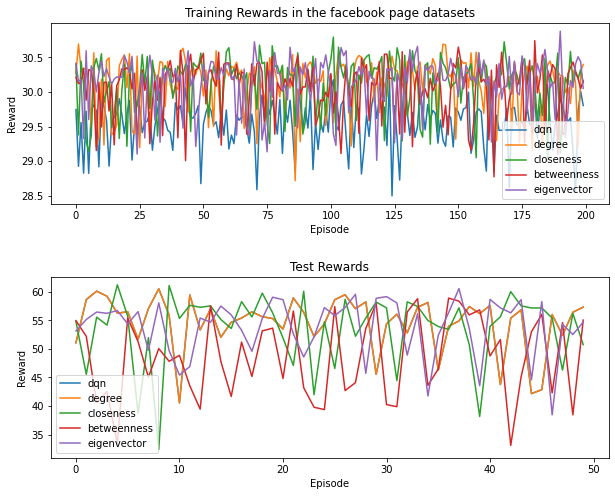

In [12]:
import matplotlib.pyplot as plt

# Data lists
rewards_list = [rewards_list_dqn_fb, rewards_list_benchmark1_fb, rewards_list_benchmark2_fb, rewards_list_benchmark3_fb, rewards_list_benchmark4_fb]
test_rewards_list = [test_rewards_list_fb, test_rewards_list_fb_benchmark1, test_rewards_list_fb_benchmark2, test_rewards_list_fb_benchmark3, test_rewards_list_fb_benchmark4]
name_list = ['dqn', 'degree', 'closeness', 'betweenness', 'eigenvector']

# Create the figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot rewards
for i, rewards in enumerate(rewards_list):
    axes[0].plot(rewards, label=name_list[i])

# Set labels and title for the first subplot
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Reward')
# axes[0].set_title('Training Rewards in the facebook page datasets')
axes[0].legend()

# Plot test rewards
for i, test_rewards in enumerate(test_rewards_list):
    axes[1].plot(test_rewards, label=name_list[i])

# Set labels and title for the second subplot
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Reward')
# axes[1].set_title('Test Rewards')
axes[1].legend()

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Show the graph
plt.show()

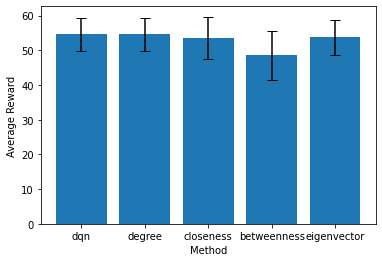

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Data lists
test_rewards_list = [test_rewards_list_fb, test_rewards_list_fb_benchmark1, test_rewards_list_fb_benchmark2, test_rewards_list_fb_benchmark3, test_rewards_list_fb_benchmark4]
name_list = ['dqn', 'degree', 'closeness', 'betweenness', 'eigenvector']

# Calculate average rewards and standard deviation
avg_rewards = [np.mean(rewards) for rewards in test_rewards_list]
std_rewards = [np.std(rewards) for rewards in test_rewards_list]

# Set the x positions of the bars
x_pos = np.arange(len(name_list))

# Plot the average rewards as a bar chart
plt.bar(x_pos, avg_rewards, yerr=std_rewards, capsize=5)

# Set the x tick positions and labels
plt.xticks(x_pos, name_list)

# Set labels and title
plt.xlabel('Method')
plt.ylabel('Average Reward')
#plt.title('Average and Standard Deviation rewards in the test set')

# Show the graph
plt.show()